# Predicting the Outcomes of European Soccer Matches





**IMPORTANT NOTE:** Our group changed our project proposal due to web scraping complications with our original proposal (predicting trending videos from various YouTube datasets). We were getting HTTP 403 Forbidden errors when trying to scrape information from socialblade.com. This data was necessary for us to have labels in our predictive models. Thus, we restarted our project, focusing on a new task: to predict the outcomes (and goal differences) of European soccer matches given a variety of data on teams, players, and matches.

The new project proposal can be found: [here](https://docs.google.com/document/d/1l9OxWg2F9bVu9biQym1FuubYL8dqyYb9-lP7bENMZzI/edit?usp=sharing).

The new dataset can be found: [here](https://www.kaggle.com/datasets/hugomathien/soccer).

## Set-up
We begin with the usual imports. If you do not yet have your kaggle API key in the root folder of your Google Drive, please follow the instructions below, taken from Homework 4:

1. Go to this [Kaggle link](https://www.kaggle.com/datasets/datasnaek/youtube-new) and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file kaggle.json
3. Upload the kaggle.json file to the default location in your Google Drive (Please DO NOT upload the json file into any specific folder)

Now, you should be good to run the following cells!

In [ ]:
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
!apt update

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 261 kB in 5s (51.3 kB/s)
Reading package li

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

Next, we'll bring in the datasets from Kaggle!

In [ ]:
# Download datasets
!!kaggle datasets download -d hugomathien/soccer

['soccer.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip /content/soccer.zip

Archive:  /content/soccer.zip
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: database.sqlite         


In [ ]:
cnx = sqlite3.connect('database.sqlite')
#read in tables
countries_df = pd.read_sql_query("SELECT * FROM Country", cnx)
leagues_df = pd.read_sql_query("SELECT * FROM League", cnx)
matches_df = pd.read_sql_query("SELECT * FROM Match", cnx)
players_df = pd.read_sql_query("SELECT * FROM Player", cnx)
player_attributes_df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
teams_df = pd.read_sql_query("SELECT * FROM Team", cnx)
team_attributes_df = pd.read_sql_query("SELECT * FROM Team_Attributes", cnx)

# Understanding Our Data
Let's take a look at our seven (!) dataframes.
- **countries_df** contains information about the various countries that are involved in the matches
- **leagues_df** contains the eleven leagues represented in the match dataset
- **matches_df** contains data on more than 26,000 matches that have been played in European leagues from 2008-2016
- **players_df** contains all the players who participated in these matches
- **player_attributes_df** contains various attributes about each player (including information about their physical capabilities and skills)
- **teams_df** contains all the teams who participated in these matches
- **team_attributes_df** contains more high-level information about team capabilities (dribbling, passing, defense, chance creation, etc.)

In [ ]:
countries_df.head(5)

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [ ]:
leagues_df.head(5)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [ ]:
matches_df.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [ ]:
players_df.head(5)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [ ]:
player_attributes_df.head(5)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [ ]:
teams_df.head(5)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [ ]:
team_attributes_df.head(5)
team_attributes_df.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

# Cleaning our Data
We'll start by exploring our datasets, and performing some operations to get them ready for visualizing and modeling. We see that some of the dataframes contain supplemental information **(countries_df, leagues_df, players_df, teams_df)** whereas the real crux of the data is in three main dataframes: **player_attributes_df, team_attributes_df, and matches_df**. 

Let's dive in!

## Player Data
Let's first look at our **player data** (players_df and player_attributes_df) to get a sense of what the data looks like.

We'll look at some descriptive statistcs for each of the player attributes (to get a sense of the ranges we're working with) and, of course, we'll check for null values.

In [ ]:
from google.colab import files
plt.rcParams["font.family"] = "serif"
sns.set(font="serif")

In [ ]:
players_df.describe()

In [ ]:
player_attributes_df.describe()

Here, we see a few things. (1) Height and weight attributes for players are stored within **players_df**. (2) We have a TON of player attributes to work with in **player_attributes_df**! So, our first step is figuring out which player attributes give us the most complete and relevant information, and which ones we can drop.

Let's start by **plotting a correlation matrix**. This will help us understand what player attributes are linked.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

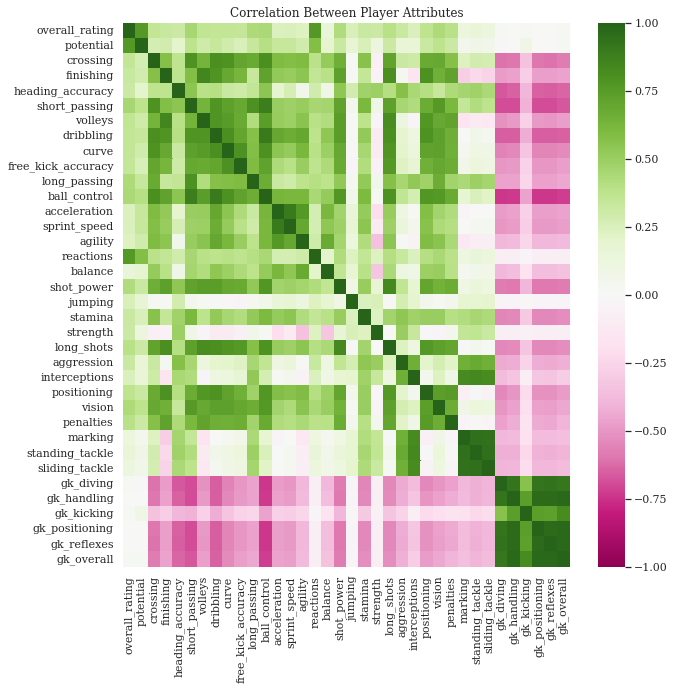

In [ ]:
#Plotting correlation heatmap
fig, ax = plt.subplots(figsize=(10, 10))

corr_matrix = player_attributes_df.drop(['id', 'player_fifa_api_id', 'player_api_id'], axis = 1).corr()
sns.heatmap(data=corr_matrix, cmap='PiYG', vmin=-1, vmax=1).set_title('Correlation Between Player Attributes')   
plt.savefig("player-correlation.png", bbox_inches='tight', dpi=300)
files.download("player-correlation.png") 

This correlation matrix reveals some pretty important things!
1. *All of our goalie attributes are strongly correlated.* We will consolidate these features into one representative goalie attribute.
2. All of our goalie attributes are *negatively correlated with most other attributes*. This makes sense, as most players are field players and don't posess strong goalie skills.
3. Strangely enough, *overall_rating and potential are not strongly correlated with any features* (except with each other and reactions). Accordingly, we will drop potential and reactions.
4. Unsurprisingly, *dribbling is highly correlated with ball control*. Since dribbling is such a revealing attribute, we'll keep this and drop ball control and short_passing.
5. Also unsurprisingly, we see that a*cceleration and sprint_speed are highly correlated*. We'll drop acceleration.
6. The attributes "long_shots" and "vision" *are highly correlated *with multiple features, so we will drop these.
7. We see that marking, standing_tackle, and sliding_tackle are almost *directly correlated with each other*. So, we'll keep marking and drop standing_tackle and sliding_tackle.

Also, unrelated to the correlation matrix, the attributes preferred_foot, attacking_work_rate, and defensive_work_rate are all objects (non-numerical). Because we want to focus on numerical assessments of our players' abilities, we will drop these too.

Let's adjust our goalie attributes and do some dropping!

In [ ]:
#Take the average of goalie-related attributes and store into an attribute called gk_overall
player_attributes_df['gk_overall'] = player_attributes_df[['gk_diving', 'gk_handling', 
                                                           'gk_kicking', 'gk_positioning', 'gk_reflexes']].mean(axis = 1)
#Dropping player attributes
player_summary_attributes = player_attributes_df.drop(labels = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 
                                                                'gk_reflexes', 'potential', 'reactions', 'ball_control',
                                                                'short_passing', 'acceleration', 'long_shots', 'vision',
                                                                'standing_tackle', 'sliding_tackle', 'preferred_foot',
                                                                'attacking_work_rate', 'defensive_work_rate'], axis = 1)

Before moving on, it doesn't make sense to keep two dataframes that contain player data, when we can consolidate. So, it's time to join our player dataframes. 

Here, we join **players_df** and **player_summary_attributes_df** on player_api_id and call this **merged_players_df**.

In [ ]:
#join dataframes
merged_players_df = players_df.merge(player_summary_attributes, left_on = 'player_api_id', right_on = 'player_api_id')
#drop redundant ids
merged_players_df = merged_players_df.drop(['id_y', 'player_fifa_api_id_y', 'id_x', 'player_fifa_api_id_x', 'birthday'], axis = 1)
merged_players_df.head(5)

,player_api_id,player_name,height,weight,date,overall_rating,crossing,finishing,heading_accuracy,volleys,...,shot_power,jumping,stamina,strength,aggression,interceptions,positioning,penalties,marking,gk_overall
0,505942,Aaron Appindangoye,182.88,187,2016-02-18 00:00:00,67.0,49.0,44.0,71.0,44.0,...,55.0,58.0,54.0,76.0,71.0,70.0,45.0,48.0,65.0,8.6
1,505942,Aaron Appindangoye,182.88,187,2015-11-19 00:00:00,67.0,49.0,44.0,71.0,44.0,...,55.0,58.0,54.0,76.0,71.0,70.0,45.0,48.0,65.0,8.6
2,505942,Aaron Appindangoye,182.88,187,2015-09-21 00:00:00,62.0,49.0,44.0,71.0,44.0,...,55.0,58.0,54.0,76.0,63.0,41.0,45.0,48.0,65.0,8.6
3,505942,Aaron Appindangoye,182.88,187,2015-03-20 00:00:00,61.0,48.0,43.0,70.0,43.0,...,54.0,58.0,54.0,76.0,62.0,40.0,44.0,47.0,62.0,7.6
4,505942,Aaron Appindangoye,182.88,187,2007-02-22 00:00:00,61.0,48.0,43.0,70.0,43.0,...,54.0,58.0,54.0,76.0,62.0,40.0,44.0,47.0,62.0,7.6


Oops!

Looking at merged_players_df, we see that we have **multiple rows corresponding to each player**. This is because our dataset contains skill assessments that were taken on multiple dates. This makes sense – as players grow and change through seasons, their skill assessments should change. 

However, in the interest of not over-complicating our predictive model, we'll say that we don't need this level of granularity. So, we'll average each player's attributes over the available date ranges to get a general idea of their skills.

In [ ]:
#group by player id and get the mean of each of their attributes
merged_players_df = merged_players_df.groupby(by = 'player_api_id').mean().reset_index()

#join with players_df to get player_name back
merged_players_df = merged_players_df.merge(players_df[['player_api_id', 'player_name']], 
                                            left_on = 'player_api_id', right_on = 'player_api_id')

#round our averages to 2 decimal points
merged_players_df = merged_players_df.round(2)

Let's take a quick look at any missing values in this merged dataframe.

In [ ]:
merged_players_df.isna().sum()

player_api_id           0
height                  0
weight                  0
overall_rating          0
crossing                0
finishing               0
heading_accuracy        0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
sprint_speed            0
agility               478
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
aggression              0
interceptions           0
positioning             0
penalties               0
marking                 0
gk_overall              0
player_name             0
dtype: int64

Out of the >11,000 players in the dataset, we see that **we're missing data on a few attributes for about 500 of these players**. Now, dropping these rows (with nans) would be harmful because we'd lose all of the other data about attributes that these 500 players have (effectively leaving us with no data on these players). Dropping the attributes (with nans) creates a data disadvantage for the ~10,600 players that we do have these attributes for. This is not an optimal solution either.

Since we only are missing a small number of attributes for a small proportion of players (< 5%), we will perform some data imputation Considering how we want to use this player data later on – to compute average player statistics for teams in played matches – we want to choose an imputation method that will skew team statistic averages *the least.* Given that there are thousands of players in this dataframe, with wide ranges of attribute scores, we will impute the missing values using the mean values of each attribute. Hopefully this means that any one single player with a missing score (ex; for agility) will not horifically bias a team's average score for that attribute (ex; drag down the team's average agility).

In [ ]:
#impute NaN values with means of the five attributes that were missing player data
merged_players_df['volleys'].fillna(value=merged_players_df['volleys'].mean(), inplace = True)
merged_players_df['curve'].fillna(value=merged_players_df['curve'].mean(), inplace = True)
merged_players_df['agility'].fillna(value=merged_players_df['agility'].mean(), inplace = True)
merged_players_df['balance'].fillna(value=merged_players_df['balance'].mean(), inplace = True)
merged_players_df['jumping'].fillna(value=merged_players_df['jumping'].mean(), inplace = True)

## Team Data
It's time to look at data (**teams_df and team_attributes_df**) on the roughly 300 teams within the 11 leagues represented in our datasets. These metrics will be able to tell us about the holistic strength and strategy of a team (based on higher-level, team-wide attributes).

Let's take a look at the types of team attributes available.

In [ ]:
team_attributes_df.isna().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

It seems like there are a **few numerical metrics** (similar to the player attributes) as well as **corresponding descriptive variables**, that may help us understand the implication of the numerical scores (i.e. whether a higher score is indicative of more team strength or not).

Now, for some of these attributes, it's fairly straightforward to interpret numerical scores. For example, higher **buildUpPlaySpeed** or **chanceCreationShooting** values are likely indicative of stronger teams – that can create plays faster and get more shots on target. However, some of these attributes are less straightforward. For example, how can we interpret "passing" metrics? Or aggression metrics? 

To answer these questions, let's try visualizing some of these descriptive attributes. Specifically, we'll look at **buildUpPlayPassing, chanceCreationPassing, defenceAggression, and defenceTeamWidth**, in an attempt to understand what they mean.

Note we won't be looking at **buildUpPlayDribbling**, because of the large amount of missing values. We also won't be looking at (or using) any of the **Positioning** attributes bold textbecause there is no corresponding numerical score for these attributes.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

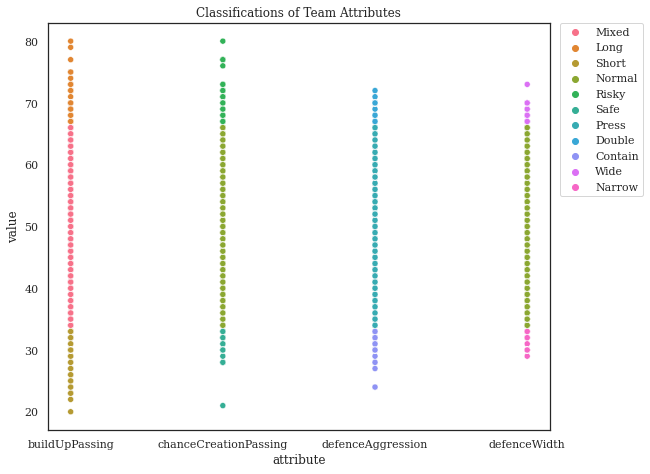

In [ ]:
# separate each of the investigated attributes into their own dataframes, with a shared "value" column corresponding
# to the numerical value of the attribute and the "descriptor" column corresponding to the classification of that value

#standardizing buildUpPlayPassing data
b_passing_for_plot = team_attributes_df[['buildUpPlayPassing', 'buildUpPlayPassingClass']].rename(
    columns = {'buildUpPlayPassing' : 'value', 'buildUpPlayPassingClass' : 'descriptor'})
b_passing_for_plot['attribute'] = 'buildUpPassing'

#standardizing chanceCreationPassing data
c_passing_for_plot = team_attributes_df[['chanceCreationPassing', 'chanceCreationPassingClass']].rename(
    columns = {'chanceCreationPassing' : 'value', 'chanceCreationPassingClass' : 'descriptor'})
c_passing_for_plot['attribute'] = 'chanceCreationPassing'

#standardizing defenceAggression data
aggression_for_plot = team_attributes_df[['defenceAggression', 'defenceAggressionClass']].rename(
    columns = {'defenceAggression' : 'value', 'defenceAggressionClass' : 'descriptor'})
aggression_for_plot['attribute'] = 'defenceAggression'

#standardizing defenceTeamWidth data
width_for_plot = team_attributes_df[['defenceTeamWidth', 'defenceTeamWidthClass']].rename(
    columns = {'defenceTeamWidth' : 'value', 'defenceTeamWidthClass' : 'descriptor'})
width_for_plot['attribute'] = 'defenceWidth'

#concatenating the individual datasets into one dataset for plot
team_attributes_for_plot = pd.concat([b_passing_for_plot, c_passing_for_plot, aggression_for_plot, width_for_plot])

#plotting the distributions (and classifications) of each attribute on a scatterplot
fig, ax = plt.subplots(figsize=(9, 7.5))
sns.scatterplot(data = team_attributes_for_plot, x = "attribute", y= "value", hue = "descriptor").set_title('Classifications of Team Attributes')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("team-attribute.png", bbox_inches='tight', dpi=300)
files.download("team-attribute.png") 

It looks like high scores for each of the four attributes (respectively) correspond with **long passing, risky passing, double defense** (two players on one opposing player, high pressure) and **wide defense formations**. Contextualizing these descriptors (with what we know about football), we'll roughly say that the higher the score for most (if not all) of the team-wide attributes, the more competitive the team is. We'll go ahead and keep all of the numerical attributes (now that we have a better idea of what they mean) save for the three we didn't look at above.

In [ ]:
#select the important team attributes (as identified)
team_summary_attributes_df = team_attributes_df[['team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlayPassing', 
                                                 'chanceCreationPassing', 'chanceCreationCrossing', 
                                                 'chanceCreationShooting','defencePressure', 
                                                 'defenceAggression', 'defenceTeamWidth']]

Again, we'll take a quick look at the correlations between our team attributes to make sure there aren't any glaringly tied-together attributes. 

Text(0.5, 1.0, 'Correlation Between Team Attributes')

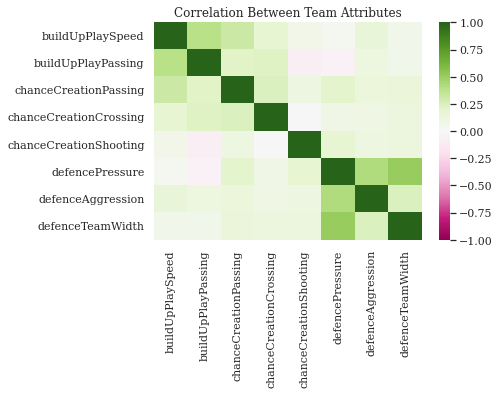

In [ ]:
#plot correlation matrix for team attributes
team_corr_matrix = team_summary_attributes_df.drop(columns = 'team_api_id').corr()
sns.heatmap(data=team_corr_matrix, cmap='PiYG', vmin=-1, vmax=1).set_title('Correlation Between Team Attributes')   

It seems like we have a pretty discrete set of attributes for our teams!

Now, just like with the players data, it doesn't make sense for us to keep the teams dataframes separate. Hence, we will merge **teams_df** and **team_summary_attributes_df** to get one dataframe, **merged_teams_df**, with all of our team-specific data. Also just like the player data, merged_teams_df has multiple rows corresponding to a single team, with multiple measurements of team-specific attributes over the eight seasons in the data. However, we will not be averaging these team-specific attributes, as it is very likely the capabilities of a team drastically change from season to season. Instead, we will take into account the date the statistics were taken on when bringing team characteristics into our matches dataframe later.

In [ ]:
#merge our teams dataframe with our team attributes dataframe, to get one dataframe that has every team's corresponding attributes
merged_teams_df = teams_df.merge(team_summary_attributes_df, left_on = 'team_api_id', right_on = 'team_api_id')

#drop any redundant ids
merged_teams_df = merged_teams_df.drop(['team_fifa_api_id', 'id'], axis = 1)

The one thing we have to account for is that for some teams, **we are missing data on certain dates**. This is not ideal, because when we bring team characteristics into our matches dataframe, we don't want to drop all the matches that were played by teams we didn't have statistics for in *that one specific season*. So, we will try to impute the team statistics for missing dates, in a similar fashion to how we filled in missing player data.

In [ ]:
#get the teams that are missing data measurements (on at leat one of the 6 measurement dates)
team_stat_count = merged_teams_df.groupby(by = 'team_api_id').count().reset_index()
missing_team_data = team_stat_count[team_stat_count['date'] < 6]['team_api_id']
len(missing_team_data)

99

We see that around 99 teams are missing data for 1 or more date measurements. We will fill in statistics for each missing date for each team by adding rows with the median statistics we *do have* for these teams (from other dates). Note, we use the median here to account for any one-off bad seasons or exceptionally good seasons of these teams.

In [ ]:
#get the dates that team statistic measurements were taken on
measurement_dates = merged_teams_df['date'].unique()
measurement_dates

array(['2010-02-22 00:00:00', '2011-02-22 00:00:00',
       '2012-02-22 00:00:00', '2013-09-20 00:00:00',
       '2014-09-19 00:00:00', '2015-09-10 00:00:00'], dtype=object)

In [ ]:
#get the median statistics for the teams we are missing data for
median_stats = merged_teams_df.groupby(by = ['team_api_id']).median().reset_index()
missing_median_stats = median_stats[median_stats['team_api_id'].isin(missing_team_data)]
#get back the dropped long name and short name
missing_median_stats = teams_df[['team_api_id', 'team_long_name', 'team_short_name']].merge(missing_median_stats, 
                                                  left_on = 'team_api_id', right_on = 'team_api_id')

In [ ]:
#create the imputed rows in team_attributes_df, for missing dates of teams missing data 
missing_rows = []

#given a team, this function creates new rows for that team's statistics on missing dates
def impute_missing_team_data(team_id):
  #get the dates we do have for team id
  present_dates = merged_teams_df[merged_teams_df['team_api_id'] == team_id]['date'].unique()

  #find the dates we don't have for team id
  missing_dates = list(set(measurement_dates).difference(present_dates))

  #add missing rows for each date 
  for date in missing_dates:
    new_date = [date]
    #get the median statistics for this team
    team_stats = missing_median_stats[missing_median_stats['team_api_id'] == team_id].values.flatten().tolist()

    #add the newly created row
    missing_rows.append(team_stats[0:3] + new_date + team_stats[3:])

#call function on every team that is missing data
for id in missing_team_data:
  impute_missing_team_data(id)

In [ ]:
#add missing rows into a new dataframe
missing_team_stat_rows = pd.DataFrame(columns = merged_teams_df.columns, data = missing_rows)

#concatenate with merged_teams_df
merged_teams_df = pd.concat([merged_teams_df, missing_team_stat_rows])

We'll do a quick check to see if we're missing any values.

In [ ]:
merged_teams_df.isna().sum()

team_api_id               0
team_long_name            0
team_short_name           0
date                      0
buildUpPlaySpeed          0
buildUpPlayPassing        0
chanceCreationPassing     0
chanceCreationCrossing    0
chanceCreationShooting    0
defencePressure           0
defenceAggression         0
defenceTeamWidth          0
dtype: int64

Looks good!

## Matches Data
Now, it's time to tackle the beast – **matches_df**. 

In this section, we'll focus on cleaning up this dataframe, and bringing in supplemental data for each match from **merged_players_df** and **merged_teams_df**. Specifically, we want to bring in the average player statistics for both sides (based on their starting formations) in every match. We also want to bring in the average team statistics for both sides in every match.

As we saw above, this dataframe contains data on over 26,000 matches, including the home and away team ids, starting player lineups, starting player formations, goals scored, and betting odds. For the purposes of our predictive model, betting data isn't really helpful. So the first step is to go ahead and **remove all columns titled with acronyms** (these acronyms are betting lingo).

In [ ]:
#drop columns corresponding to betting
matches_df = matches_df.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
                              'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD',
                              'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], axis = 1)

Next, we want to drop any match statistics that are computed *while the match is being played*. Why? It's because our goal is to build a predictive model that can determine which team (in a matchup) will prevail as the winner! Now obviously, it's much easier to predict the winner of a game while the game is being played – metrics like number of crosses made or possession tend to be higher in-match for the team that has the advantage. However, in real-life, when we try to predict who will win a match before the match is played, we won't have these in-match metrics. So, it makes sense to train a model that can predict the winner well using only what is known about the teams *before the game is played*.

In [ ]:
#drop in-match statistics 
matches_df = matches_df.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'], axis = 1)

Now, we have 66 columns in **matches_df** that correspond to the starting players of the home and away teams. There are 3 columns per each of the 22 starting players, with the following suffixes: player_X, player_Y, player_num. These columns correspond to the X and Y coordinates of the player (in the starting formation) and the player's id (a foreign key that identifies players in our merged_players_df), respectively. The formation data isn't really helpful for a predictive model, so we'll drop it. Also, some rows (individual matches) are likely missing player data. So, we want to make sure we're only keeping matches where we have at least half of the starting players' ids (6 players on each side).

In [ ]:
#getting column names that contain formation data
match_player_coords = matches_df.columns[11:55] 

#getting column names that contain starting roster players for the home team 
home_match_players = matches_df.columns[55:66]

#getting column names that contain starting roster players for the away team
away_match_players = matches_df.columns[66:77] 

#dropping the columns that contain formation data
matches_df = matches_df.drop(columns = match_player_coords)

#dropping the rows that don't have enough information about our starting players (ie. don't have ids for more than six players)
matches_df = matches_df.dropna(subset = home_match_players, thresh = 6) 
matches_df = matches_df.dropna(subset = away_match_players, thresh = 6)

Next, there are two columns in matches_df that tell us how many goals were scored in each game by the home team and by the away team: **home_team_goal** and **away_team_goal**. Since we are trying to predict which team will win a game (home or away), we want to use these two columns to add a label column, which we'll call **home_win**. This label will be 1 if the home team wins, 0 if the home team and away team tie, and -1 if the away team wins. We can use this label for a classification model.

In [ ]:
#convert the home_team_goal and away_team_goal columns into a home_win label 
def home_win(x, y):
  if x > y:
    return 1
  if x == y:
    return 0
  else:
    return -1

matches_df['home_win'] = matches_df.apply(lambda x : home_win(x.home_team_goal, x.away_team_goal), axis = 1)

We can also use these columns to add a **goal_difference** column, which will hold the difference in goals between the home team and the away team. We can use this as a label for a linear regression model.

In [ ]:
matches_df['goal_difference'] = matches_df.apply(lambda x : x.home_team_goal - x.away_team_goal, axis = 1)

Remember that we still have 22 columns in matches_df that give us the ids of the 22 players that started for the home and away teams. In order to get the average of the player attributes we identified above, for both the home and away team's starting lineups, we need to manipulate these columns in a fashion that makes it easier to "look up" the starting players' statistics in **merged_players_df**. So, we consolidate each of the starting player columns into nested lists within two new columns: **home_players** and **away_players**. After doing that, we can drop the 22 individual columns with player ids, to form **cleaned_matches_df**.

In [ ]:
#consolidate the 11 home player ids into a nested list within 'home_players'
matches_df['home_players'] = matches_df[['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
                                'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
                                'home_player_9', 'home_player_10', 'home_player_11']].values.tolist()

#consolidate the 11 home player ids into a nested list within 'away_players'
matches_df['away_players'] = matches_df[['away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
                                'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
                                'away_player_9', 'away_player_10', 'away_player_11']].values.tolist()

In [ ]:
#drop the 22 columns with individual player ids to form cleaned_matches_df
match_players = matches_df.columns[11:33]
cleaned_matches_df = matches_df.drop(columns = match_players)

Now that we have lists of our starting players, we want to get the **average attribute values** for each of our starting lineups (home and away) in every match. This will require the following steps:
1. Defining a list, **match_data**, which we'll sequentially build up with the average player attributes for every match in the dataset.
2. Defining a function, **get_player_attributes** that gets the average of the player attributes from merged_players_df, given lists of home and away players.
3. Build a supplementary dataframe **match_player_stats**, from the **match_data** list of lists, where each column corresponds to an averaged attribute of the starting players (home and away sides).
4. Join this supplementary dataframe with **cleaned_matches_df** to have averaged player attributes for every match.

In [ ]:
#Step 1: defining an empty list to hold average player attributes for every match
match_data = []

In [ ]:
#Step 2: defining a function that'll get the average of player attributes from merged_players_df
#WARNING: this cell may take up to 2 minutes to run
def get_player_attributes(match_id, home_players, away_players):

  #clean out any nans from player lists
  home_players = [id for id in home_players if str(id) != 'nan']
  away_players = [id for id in away_players if str(id) != 'nan']

  #get rows corresponding to player statistics for home and away players
  hp_stats = merged_players_df[merged_players_df['player_api_id'].isin(home_players)].drop(labels = 
                                                                                           ['player_api_id', 'player_name'], axis = 1)
  ap_stats = merged_players_df[merged_players_df['player_api_id'].isin(away_players)].drop(labels = 
                                                                                           ['player_api_id', 'player_name'], axis = 1)
  #get average player statistics for home and away team
  hp_avg_stats = hp_stats.drop(columns='gk_overall').mean(axis = 0).round(2).tolist()
  ap_avg_stats = ap_stats.drop(columns='gk_overall').mean(axis = 0).round(2).tolist()

  hp_gk_stats = [hp_stats['gk_overall'].max().round(2)]
  ap_gk_stats = [ap_stats['gk_overall'].max().round(2)]

  #add to match statistics data
  match_id = [match_id]
  match_data.append(match_id + hp_avg_stats + hp_gk_stats + ap_avg_stats + ap_gk_stats)

#get average player statistics for all matches in dataset
cleaned_matches_df.apply(lambda x : get_player_attributes(x.match_api_id, x.home_players, x.away_players), axis = 1)

144      None
145      None
146      None
147      None
148      None
         ... 
25974    None
25975    None
25976    None
25977    None
25978    None
Length: 24713, dtype: object

In [ ]:
#Step 3a: build the column names for our supplementary dataframe
home_team_columns = ['hp_avg_' + attr for attr in merged_players_df.columns[2:].tolist()]
away_team_columns = ['ap_avg_' + attr for attr in merged_players_df.columns[2:].tolist()]
match_player_stat_cols = ['match_id'] + home_team_columns + away_team_columns

In [ ]:
#Step 3b:create a supplementary dataframe with our average player stats for each match
match_player_stats = pd.DataFrame(columns = match_player_stat_cols, data = match_data)

In [ ]:
#Step 4: merge the supplementary player stats dataframe into cleaned_matches_df
cleaned_matches_df = cleaned_matches_df.merge(match_player_stats, left_on = 'match_api_id', right_on = 'match_id')
cleaned_matches_df.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,ap_avg_jumping,ap_avg_stamina,ap_avg_strength,ap_avg_aggression,ap_avg_interceptions,ap_avg_positioning,ap_avg_penalties,ap_avg_marking,ap_avg_gk_overall,ap_avg_player_name
0,145,1,1,2008/2009,24,2009-02-28 00:00:00,493016,9996,8635,1,...,65.15,68.76,70.27,69.22,66.57,60.58,56.39,57.12,54.14,68.62


## Final Joining and Building Model/Visualization-Ready Dataframes

Now that we have the averaged player stats in our **cleaned_matches_df**, we have a few final steps before we can jump into EDA and modeling. These are:
1. Replace the **country_id** with the country name from **countries_df**
2. Replace the **league_id** with the league name from **leagues_df**
3. Join the team statistics, from **merged_teams_df**, for the teams played in every match (by date ranges) with **cleaned_matches_df**
4. Drop redundant/unnecessary columns, including: *season, stage, redudant labels, and consolidated player lists*

In [ ]:
#Step 1: Replace country_id with country name
cleaned_matches_df = cleaned_matches_df.merge(countries_df.rename(columns = {'name' : 'country_name'}), left_on = 'country_id', right_on = 'id').drop(
    columns = ['id_x', 'id_y', 'country_id'])

In [ ]:
#Step 2: Replace league_id with league name
cleaned_matches_df = cleaned_matches_df.merge(leagues_df.rename(columns = {'name' : 'league_name'}), left_on = 'league_id', right_on = 'id').drop(
    columns = ['country_id', 'id'])

In [ ]:
#Step 3a: recall we already have the dates on which team statistics were measured
measurement_dates

array(['2010-02-22 00:00:00', '2011-02-22 00:00:00',
       '2012-02-22 00:00:00', '2013-09-20 00:00:00',
       '2014-09-19 00:00:00', '2015-09-10 00:00:00'], dtype=object)

In [ ]:
#Step 3b: add a column to cleaned_matches_df that tells us what date team statistics we should pull
def get_team_stat_date(x):
  for d in measurement_dates[::-1]:
    if x >= d:
      return d
  return measurement_dates[0]

cleaned_matches_df['team_stat_date'] = cleaned_matches_df['date'].apply(lambda x : get_team_stat_date(x))

In [ ]:
#Step 3: Join team statistics from merged_teams_df with cleaned_matches_df

#merge to get home team statistics
final_matches_df = cleaned_matches_df.merge(merged_teams_df.add_prefix('ht_'),
                                            left_on = ['home_team_api_id', 'team_stat_date'],
                                            right_on = ['ht_team_api_id', 'ht_date'])

#merge to get away team statistics
final_matches_df = final_matches_df.merge(merged_teams_df.add_prefix('at_'), 
                                          left_on = ['away_team_api_id', 'team_stat_date'],
                                          right_on = ['at_team_api_id', 'at_date'])

In [ ]:
#Step 4: drop unnecessary/redundant columns in final_matches_df 
final_matches_df = final_matches_df.drop(columns=['stage', 'match_id', 'ht_team_api_id', 'at_team_api_id', 'home_players', 'away_players'])

Last thing, before we move on to EDA.

For visualization, we want to keep descriptive columns, like country_name, league_name, ht_team_long_name, and at_team_long_name.

For modeling, however, we want to keep the numerical encodings of these features. That means keeping home_team_api_id, away_team_api_id, and league_id and dropping the other descriptive columns.

In [ ]:
final_matches_visualization = final_matches_df.drop(columns = ['match_api_id', 'league_id'])

final_matches_modeling = final_matches_df.drop(columns = ['season', 'country_name', 'league_name', 'ht_team_long_name', 'at_team_long_name', 'ht_team_short_name', 'at_team_short_name'])

And that's all for data cleaning and integration! Time to move to EDA :)

# Exploratory Data Analysis (EDA)

In this section, we want to look at our player, team, and match datasets in more depth (and see if we can identify any trends in teams that have performed historically well). Some questions we'll seek to answer are:

1.   What attributes do the players with the highest overall ratings have in common? 
2.   Are some leagues more competitive than others?
3.   What team attributes are the winningest teams strong in? 
4.   What do the offensive statistics look like for the teams who have the most goals scored? What do the average player attributes look like for the top goal scorers?
5.   What do the defensive statistics look like for the teams who have the least goals conceded? What do the average player attributes look like for the minimum goal conceders?
6.   Have leagues become more competitive over time?
7.   How have the winningest teams changed over time?

## Analyzing the players with highest overall rating
We start by getting data on the top 100 and 200 players (as well as the top 50 goalies) in merged_players_df with the highest overall_rating attribute.

In [ ]:
#sorting merged_players_df by overall_rating (highest to lowest)
top_players = merged_players_df.sort_values(by = 'overall_rating', ascending = False).reset_index().drop(columns='index')
top_100_players = top_players.head(100)
top_200_players = top_players.head(200)

#get top 50 goalies by sorting with gk_overall
top_50_goalies = merged_players_df.sort_values(by = 'gk_overall', ascending = False).reset_index().drop(columns='index').head(50)

top_players.head(3)


,player_api_id,height,weight,overall_rating,crossing,finishing,heading_accuracy,volleys,dribbling,curve,...,jumping,stamina,strength,aggression,interceptions,positioning,penalties,marking,gk_overall,player_name
0,30981,170.18,159.0,92.19,83.35,92.23,69.27,87.54,96.46,87.69,...,69.65,77.54,59.69,49.27,34.23,90.54,80.15,18.77,14.85,Lionel Messi
1,30893,185.42,176.0,91.28,83.88,91.12,85.52,85.56,92.64,88.00,...,93.04,87.60,78.68,61.28,35.64,86.48,83.60,22.12,15.36,Cristiano Ronaldo
2,30924,170.18,159.0,88.46,85.17,77.75,48.54,82.04,92.92,86.83,...,54.29,74.17,63.83,59.17,46.12,84.04,81.50,18.71,13.18,Franck Ribery


###Looking at Player Attribute Distributions
Unsurprisingly, we see that two of the greats – Lionel Messi and Cristiano Ronaldo are at the top of this rating. Let's look at the distributions of each of the player attributes within the top 200 players.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

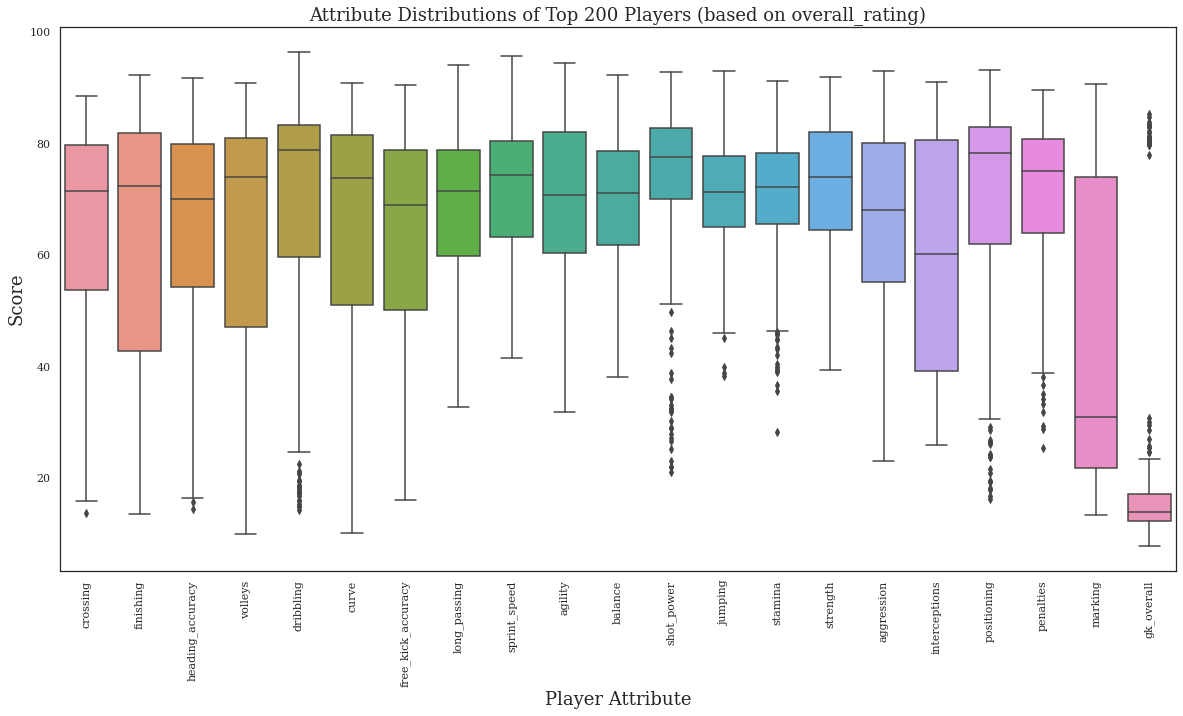

In [ ]:
#standardizing seaborn style
sns.set_style(style = 'white')
sns.set_theme(style = 'white', font='serif')
#plotting player attribute distributions as a box plot
fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(rotation=90)
sns.boxplot(data = top_200_players.drop(columns=['player_api_id', 'player_name', 'overall_rating', 'height', 'weight']))
plt.title('Attribute Distributions of Top 200 Players (based on overall_rating)', fontsize = 18)
plt.ylabel('Score', fontsize = 18)
plt.xlabel('Player Attribute', fontsize = 18)

plt.savefig("player-distribution.png", bbox_inches='tight', dpi=300)
files.download("player-distribution.png") 

There are some interesting takeaways here.

*   Upper bounds on the boxplot for each attribute are within all within the same range. This likely means that some of the top overall-rated players are the highest scorers on specific attributes.
*   Attributes like **sprint_speed, strength, and balance**, which are more a result of biology than skill, have the tighest complete distributions (including outliers). This makes sense as, presumably to some extent, the best and overall-players are naturally physically gifted.
*   Attributes like **shot_power, jumping, and stamina**, are tightly distributed, save for a set of outliers (which is larger on shot_power). It will be interesting to investigate if these outliers are a function of position – i.e. perhaps some of the top overall-rated players are defenders, who have relatively lower shot power.
*    Attributes like **intercepting, and marking** have wide distributions. This may indicate that high scores on these attributes do not necessarily influence overall rating as much.
*   The distribution of the **gk_overall** attribute is comparatively much lower. This makes sense as most of the top-rated players, like Ronaldo and Messi, are likely not goalkeepers. On the other hand, the outliers on the top end of the boxplot probably represent goalkeepers with high overall ratings.

###Individual Attributes vs. Overall Rating
Let's pick a few of these to plot against overall rating. We'll look at **sprint_speed, shot_power, and marking**.

In [ ]:
#getting dataframes for plotting
sprint_speed_df = top_100_players[['player_name', 'overall_rating', 'sprint_speed']]
shot_power_df = top_100_players[['player_name', 'overall_rating', 'shot_power']]
marking_df = top_100_players[['player_name', 'overall_rating', 'marking']]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

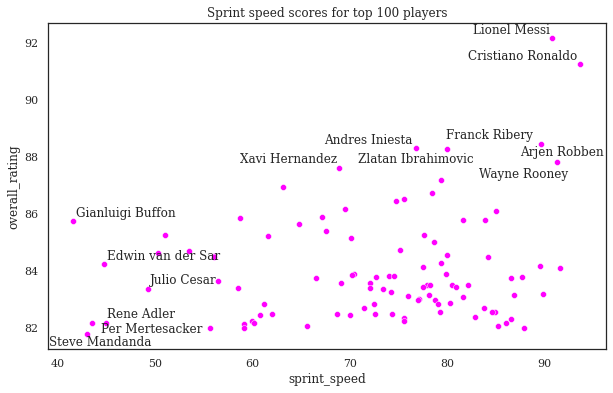

In [ ]:
#PLOTTING SPRINT SPEED
from adjustText import adjust_text #library that prevents overlapping labels
#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))

#creating scatterplot object
ss = sns.scatterplot(data = sprint_speed_df, y = 'overall_rating', x = 'sprint_speed', color = 'magenta')

#adding player name labels for players with highest sprint_speed
texts = [ss.text(sprint_speed_df.sprint_speed[i], sprint_speed_df.overall_rating[i],
                 sprint_speed_df.player_name[i], ha='center', va='center') for i in range(0,sprint_speed_df.shape[0])
                 if (sprint_speed_df.overall_rating[i] > 87) | (sprint_speed_df.sprint_speed[i] < 50)]

#call imported method to prevent overlapping labels
adjust_text(texts)
plt.title('Sprint speed scores for top 100 players')
plt.savefig("sprint-speed.png", bbox_inches='tight', dpi=300)
files.download("sprint-speed.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

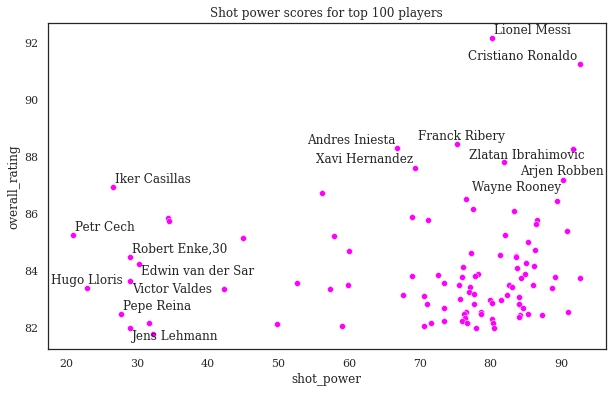

In [ ]:
#PLOTTING SHOT POWER
#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))

#creating scatterplot object
sp = sns.scatterplot(data = shot_power_df, y = 'overall_rating', x = 'shot_power', color = 'magenta')

#adding player name labels for players with highest shot power
texts = [sp.text(shot_power_df.shot_power[i], shot_power_df.overall_rating[i],
                 shot_power_df.player_name[i], ha='center', va='center') for i in range(0,shot_power_df.shape[0])
                 if (shot_power_df.overall_rating[i] > 87) | (shot_power_df.shot_power[i] < 31)]

#call imported method to prevent overlapping labels
adjust_text(texts)
plt.title('Shot power scores for top 100 players')
plt.savefig("shot-power.png", bbox_inches='tight', dpi=300)
files.download("shot-power.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

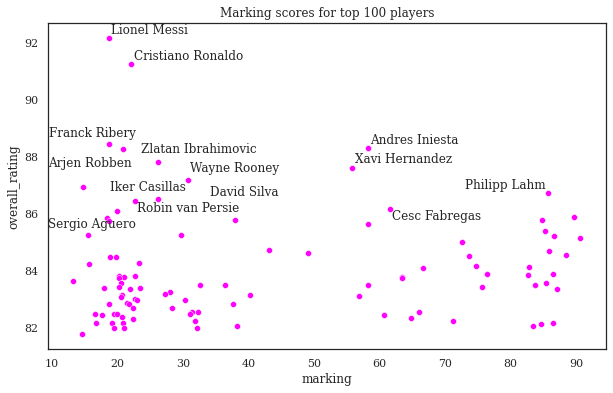

In [ ]:
#PLOTTING MARKING
#setting figure size
fig, ax = plt.subplots(figsize=(10, 6))

#creating scatterplot object
m = sns.scatterplot(data = marking_df, y = 'overall_rating', x = 'marking', color = 'magenta')

#adding player name labels for players with highest marking score
texts = [m.text(marking_df.marking[i], marking_df.overall_rating[i],
                 marking_df.player_name[i], ha='center', va='center') for i in range(0,marking_df.shape[0])
                 if marking_df.overall_rating[i] > 86]

#call imported method to prevent overlapping labels
adjust_text(texts)
plt.title('Marking scores for top 100 players')
plt.savefig("marking.png", bbox_inches='tight', dpi=300)
files.download("marking.png") 

There are a few important observations to be made from these graphs. The first, more broadly, is that none of the top 100 players are (low) outliers on any of the observed attributes (sprint speed, shot power, and marking). That is to say, we can reasonably conclude it is unlikely for a player who is badly scored on one of the attributes (i.e. not in the 82+ range), to be considered one of the top overall players. The second is that a player's position (i.e. goalkeepers & defenders vs. strikers & wingers) can explain some of the variance in attributes within the top players. For example
*    The top players on the lower end of the sprint_speed attribute, like Gianluigi Buffon and Edwin van der Sar, are **goalkeepers** whereas the top players on the higher end of the sprint_speed attribute, like Lionel Messi and Cristiano Ronaldo are **forwards/strikers**. This makes sense and explains some of that variance!
*    The same thing can again be said for the stamina attribute.
*    Conversely, the top players on the higher end of the marking attribute, like Philipp Lahm and Cesc Fabregas, are **defenders/midfielders**, where as the top players on the lower end of the marking attribute are **forwards/strikers**. Again, this helps explain some of that variance we initially saw.

###Looking at Goalie Attribute Distributions
The last thing we want to do to investigate the player data, is to look more into this cluster of top goalies. We'll look at them a little bit more.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

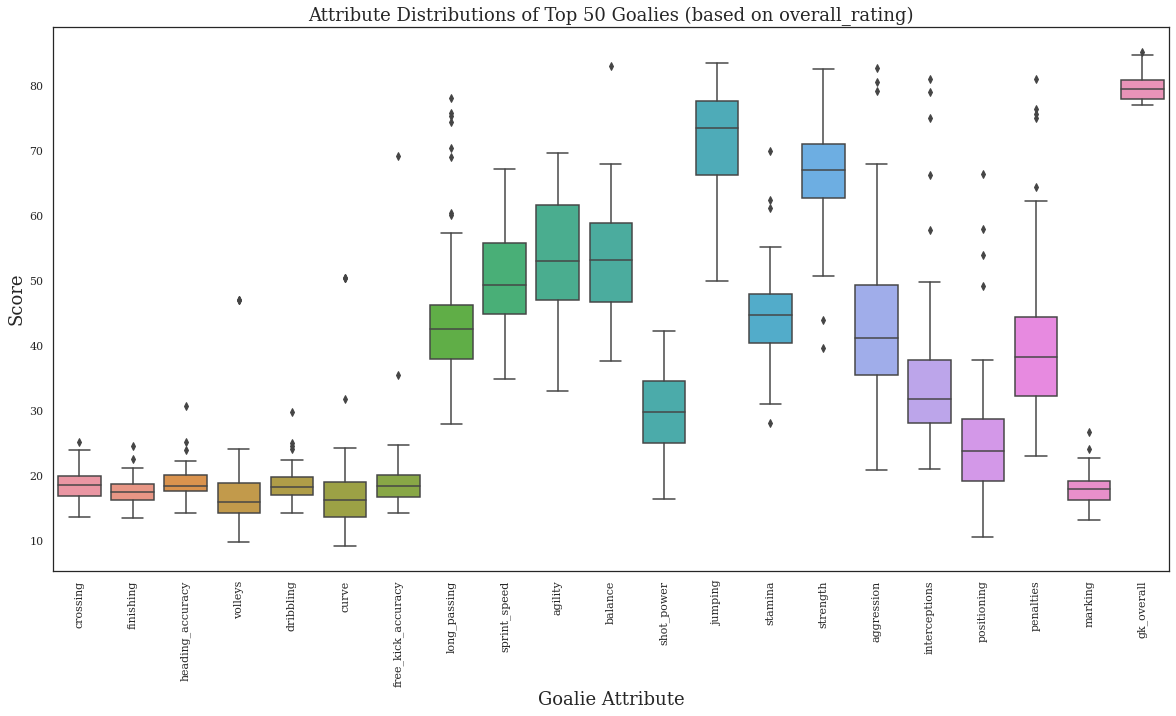

In [ ]:
#Plot top goalie attribute distribution
fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(rotation=90)
sns.boxplot(data = top_50_goalies.drop(columns=['player_api_id', 'player_name', 'overall_rating', 'height', 'weight']))
plt.title('Attribute Distributions of Top 50 Goalies (based on overall_rating)', fontsize = 18)
plt.ylabel('Score', fontsize = 18)
plt.xlabel('Goalie Attribute', fontsize = 18)

plt.savefig("goalie-distribution.png", bbox_inches='tight', dpi=300)
files.download("goalie-distribution.png") 

As expected, we can see that for goalkeepers, a whole other subset of features go into determining their overall_rating. This subset includes: the **gk_overall, jumping, strength, agility, and balance** attributes.

##Are some leagues more competitive than others?

Let's investigate the attributes for each match and visualize them between the different leagues in our dataset. We will start by creating a dataframe that groups the average team and player attributes within each league of our dataset. Then, we will compare a few key attributes between the leagues. Specifically, we will look at **average player rating, average player speed, average player shot power, average player finishing, average player marking, and average player dribbling**.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

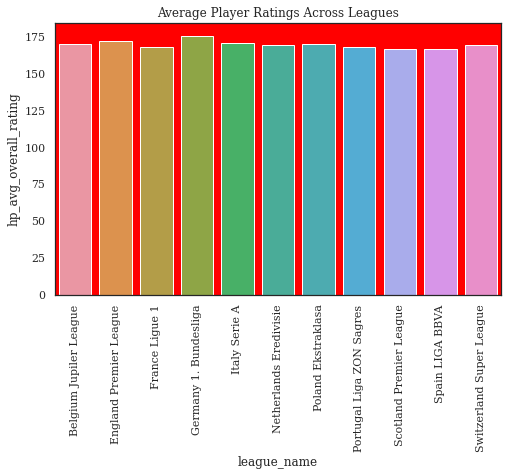

In [ ]:
#getting match data grouped by league (taking averages of match statistics)
grouped_matches_leagues = final_matches_visualization.groupby(['league_name']).mean().reset_index()
grouped_matches_leagues_ratings = grouped_matches_leagues[['hp_avg_overall_rating', 'league_name']]

#plotting the average player ratings across leagues (across all seasons)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_matches_leagues_ratings, x='league_name', y='hp_avg_overall_rating').set(Title= 
            'Average Player Ratings Across Leagues', facecolor='red')
plt.xticks(rotation=90)

plt.savefig("avgrating.png", bbox_inches='tight', dpi=300)
files.download("avgrating.png")

In this histogram displaying the distribution for the average player ratings across the leagues in the matches dataframe, we see that there is a relatively even distribution of player ratings overall.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

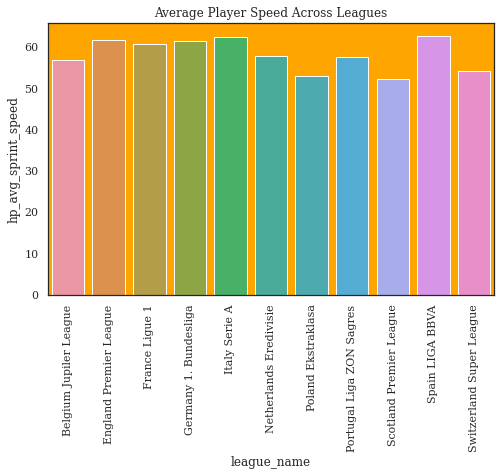

In [ ]:
grouped_matches_leagues_speed = grouped_matches_leagues[['hp_avg_sprint_speed', 'league_name']]

#plotting the average player speed across leagues (across all seasons)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_matches_leagues_speed, x='league_name', y='hp_avg_sprint_speed').set(Title= 'Average Player Speed Across Leagues', facecolor='orange')
plt.xticks(rotation=90)

plt.savefig("avgspeed.png", bbox_inches='tight', dpi=300)
files.download("avgspeed.png") 

To contrast with the average overall player ratings across each league in the matches dataframe, we see that the sprint speed had less disparity. The top 200 players visualization revealed that sprint speeds have a tighter complete distribution, so this factor may help us differentiate more effective players between teams and leagues, and therefore help influence the performance of their team in a match. This difference also illustrated that Poland Ekstraklasa had lower average speed and average player ratings compared to the other 10 leagues. This could indicate that Poland Ekstraklasa is a less competitive league, and may be an important consideration for our models – the outcome of matches in more competitive leagues may be influenced by a higher number of factors than in a less competitive league. 

Here we choose to use data for home players for each league because both statistics for home players and away players within the same league yields the same results due to the computation of each feature as an average across the entire league. Now that we have seen some differences between the average home player srint speeds and overall ratings, let's explore the differences in other major features across all leagues.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

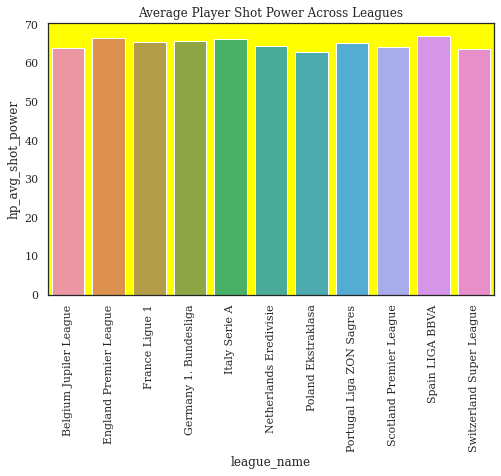

In [ ]:
grouped_matches_leagues_shot = grouped_matches_leagues[['hp_avg_shot_power', 'league_name']]

#plotting the average player shot power across leagues (across all seasons)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_matches_leagues_shot, x='league_name', y='hp_avg_shot_power').set(Title= 'Average Player Shot Power Across Leagues', facecolor='yellow')
plt.xticks(rotation=90)

plt.savefig("avgshot.png", bbox_inches='tight', dpi=300)
files.download("avgshot.png")

Here we see that there is even more variation between the leagues in their average player shot power. We saw that player shot power was tightly distributed in the previous visualizations. If we consider the implications of this disparity, we can draw several conclusions. First we can hypothesize that player shot power is related to goal scoring ability because we saw in the heatmap for player attributes that the show power is highly correlated to other ball-handling skills such as dribbling and passing accuracy. Another important aspect to note is that Poland Ekstraklasa has performed comparatively poorly on all the attributes considered so far, so we can start to draw conlcusions about the (perhaps lesser) competitive nature of this league compared to the others. We also see four leagues (**England Premier League, Germany 1. Bundesliga, Italy Serie A, and Spain LIGA BBVA**) emerging as superior in each of these categories. This could imply that these four leagues are the most competitive – we will look at comparisons for a few more attributes to confirm this intuition. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

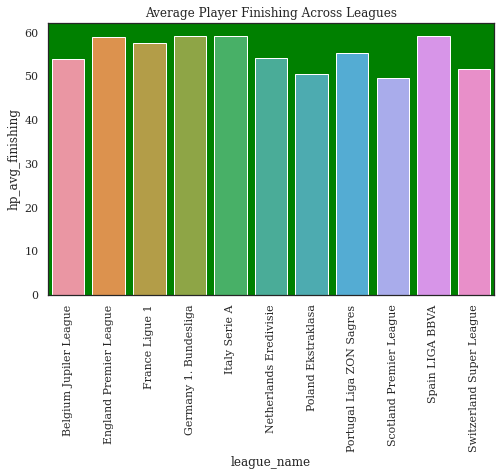

In [ ]:
grouped_matches_leagues_big = grouped_matches_leagues[['hp_avg_finishing', 'hp_avg_marking', 'hp_avg_dribbling', 'league_name']]

#plotting the average player finishing scores across leagues (across all seasons)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_matches_leagues_big, x='league_name', y='hp_avg_finishing').set(Title= 'Average Player Finishing Across Leagues', facecolor='green')
plt.xticks(rotation=90)

plt.savefig("avgfinishing.png", bbox_inches='tight', dpi=300)
files.download("avgfinishing.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

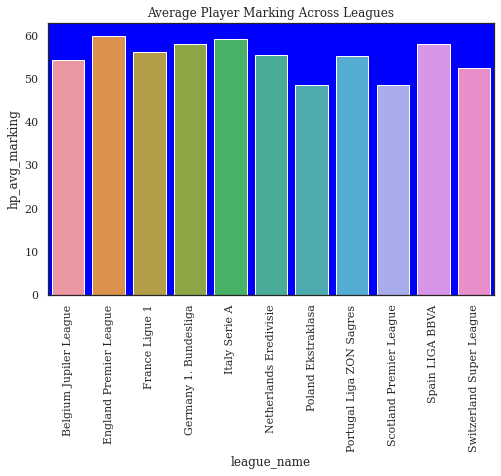

In [ ]:
#plotting the average player marking across leagues (across all seasons)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_matches_leagues_big, x='league_name', y='hp_avg_marking').set(Title= 'Average Player Marking Across Leagues', facecolor='blue')
plt.xticks(rotation=90)

plt.savefig("avgmarking.png", bbox_inches='tight', dpi=300)
files.download("avgmarking.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

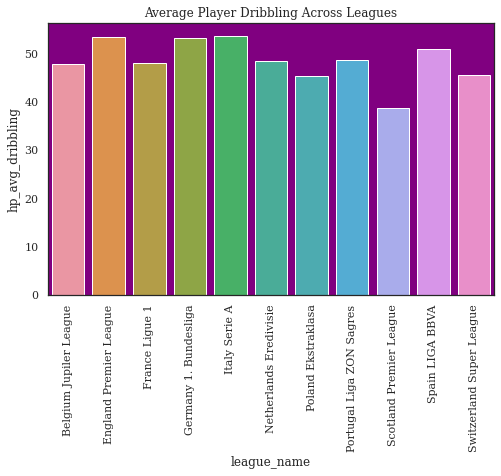

In [ ]:
#plotting the average player dribbling across leagues (across all seasons)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_matches_leagues_big, x='league_name', y='hp_avg_dribbling').set(Title= 'Average Player Dribbling Across Leagues', facecolor='purple')
plt.xticks(rotation=90)

plt.savefig("avgdribbling.png", bbox_inches='tight', dpi=300)
files.download("avgdribbling.png")

It looks like we can start to differentiate between league competitiveness based on a few major attributes: **average player speed, finishing, marking, and dribbling.** These analyses confirm our earlier hypothesis that the most competitive leagues are the English Premier League, the Spanish LIGA BBVA, Germany's Bundesliga, and Italy Serie A (not that surprising!).

##Analyzing the winningest teams in the English Premier League and the Spanish LaLiga


Next up, we'll perform a bit more complicated analysis on our winningest teams, across leagues, and across seasons. Specifically, we'll focus on the winningest teams within two of the more competitive leagues (based on our prior analysis): the English Premier League and the Spanish LIGA BBVA (LaLiga). 

For these winningest teams, we'll look at the team attributes to understand what features are shared by the most successful teams. We'll also look at the average player attributes across these winningest teams to answer a few questions: are these teams better than average? Are there any one or two specific attributes that are indicators of a team's underlying strength?

Let's start by creating the necessary dataframes for this analysis.

In [ ]:
english_matches = final_matches_visualization[final_matches_visualization['league_name'] == 'England Premier League']
spanish_matches = final_matches_visualization[final_matches_visualization['league_name'] == 'Spain LIGA BBVA']

Let's also split **english_matches** and **spanish_matches** by season to get more granular. 

In [ ]:
#gets the match frames for each league by season
def getMatchFrames(x, seasons):
  matchFrames = []
  for season in seasons:
    matchFrames.append(x[x['season'] == season])
  return matchFrames

#list of seasons
seasons = ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
           '2013/2014', '2014/2015', '2015/2016']
#build list of seasonal matches for each league, to make it easier to run by season-by-season analysis
matchFrames_english = getMatchFrames(english_matches, seasons)
matchFrames_spanish = getMatchFrames(spanish_matches, seasons)


Next we'll define a function, getWinning, that take in a dataframe for one season, and outputs the **x** winnigest teams in that season, along with their full name, id, and number of wins.

In [ ]:
#get the x winnigest teams, given a dataframe with all of a league's matches in a given season
def getWinning(df, x) :
  #get a copy so we don't modify the input dataframes directly
  input_df = df.copy()

  #modify away_win and home_win columns to make it simpler to count
  input_df['away_win'] = [1 if x == -1 else 0 for x in input_df['home_win']]
  input_df['home_win'] = input_df['home_win'].replace(-1, 0)

  #group by home team and sum home wins
  input_df_h = input_df.groupby(by=['home_team_api_id', 'ht_team_long_name', 
                                    'season']).sum().reset_index()[['home_win', 'home_team_api_id', 'ht_team_long_name', 'season']]

  #group by away team and sum away wins
  input_df_a = input_df.groupby(by=['away_team_api_id', 'at_team_long_name']).sum().reset_index()[[
      'away_win', 'away_team_api_id', 'at_team_long_name']]

  #merge the home wins and away wins dataframes, on home team id and away team id to get all wins of a team (home and away)
  input_df_wins = input_df_h.merge(input_df_a, left_on='home_team_api_id', right_on ='away_team_api_id')

  #sum up total wins
  input_df_wins['total_wins'] = input_df_wins['home_win'] + input_df_wins['away_win']
  
  input_df_wins = input_df_wins[['home_team_api_id', 'total_wins', 'ht_team_long_name', 'season']].rename(
      columns={'home_team_api_id': "id", 'ht_team_long_name': "name"}).sort_values(by='total_wins', ascending=False)
  return input_df_wins.head(x)



```
# This is formatted as code
```

Next, we'll define a function getWinningAcrossSeasons that outputs the **x** winningest teams across all seasons for a given league.

In [ ]:
#given a list of dataframes, dfs, and the number of winners, x, to obtain each season, this 
#function outputs a dataframe that contains all of the n winners per season in a given league
def getWinningAcrossSeason(dfs, x):
  winners = []
  for season in dfs:
    winners.append(getWinning(season, x))
  return pd.concat(winners)

In [ ]:
#get the team with the most wins in every season for both leagues
englishWinners = getWinningAcrossSeason(matchFrames_english, 1)
spanishWinners = getWinningAcrossSeason(matchFrames_spanish, 1)

Let's look at who the winners were in every season for the Premier League and LaLiga!

In [ ]:
englishWinners

,id,total_wins,name,season
18,10260,28,Manchester United,2008/2009
19,10260,27,Manchester United,2009/2010
18,10260,23,Manchester United,2010/2011
18,10260,28,Manchester United,2011/2012
18,10260,28,Manchester United,2012/2013
2,8456,27,Manchester City,2013/2014
2,8455,26,Chelsea,2014/2015
0,8197,23,Leicester City,2015/2016


In [ ]:
spanishWinners

,id,total_wins,name,season
9,8634,27,FC Barcelona,2008/2009
6,8633,31,Real Madrid CF,2009/2010
9,8634,30,FC Barcelona,2010/2011
11,8633,32,Real Madrid CF,2011/2012
12,8634,32,FC Barcelona,2012/2013
14,9906,28,Atlético Madrid,2013/2014
10,8633,30,Real Madrid CF,2014/2015
12,8634,29,FC Barcelona,2015/2016


We can see that there are a few teams that have consistently been killing it, and winning the most: **Manchester United, FC Barcelona, and Real Madrid CF**.

We'll go ahead and plot some of the team characteristics of these teams in their winning seasons. We'll look at:


*   Manchester United in the 2010/2011 season
*   Manchester City in the 2013/2014 season
*   FC Barcelona in the 2012/2013 season
*   Real Madrid CF in the 2014/2015 season

We will plot the team's attribute within the season alongside the average of every other team's attributes in that season. This will tell us a bit about the team characteristics these winningest teams shared.



In [ ]:
#columns that contain team attributes
attr_cols = matchFrames_english[0].columns[59:70].tolist()
vis_cols = [attr_cols[0]] + attr_cols[3:]

#get the statistics for each team in the given season, and the average of the other teams in the given season
#statistics for Manchester United
engl_2010 = matchFrames_english[2]
manu_2010 = engl_2010[engl_2010['home_team_api_id'] == 10260][attr_cols].drop(columns=['ht_team_short_name',
                                                                                       'ht_date']).iloc[0].tolist()
other_2010 = engl_2010[engl_2010['home_team_api_id'] != 10260]
other_2010 = ['other'] + engl_2010.drop_duplicates('home_team_api_id')[attr_cols].mean().tolist()

#statistics for Chelsea
engl_2013 = matchFrames_english[5]
mc_2013 = engl_2013[engl_2013['home_team_api_id'] == 8456][attr_cols].drop(columns=['ht_team_short_name',
                                                                                       'ht_date']).iloc[0].tolist()
other_2013 = engl_2013[engl_2013['home_team_api_id'] != 8456]
other_2013 = ['other'] + engl_2013.drop_duplicates('home_team_api_id')[attr_cols].mean().tolist()

#statistics for FC Barcelona
span_2012 = matchFrames_spanish[4]
fcb_2012 = span_2012[span_2012['home_team_api_id'] == 8634][attr_cols].drop(columns=['ht_team_short_name',
                                                                                       'ht_date']).iloc[0].tolist()
other_2012 = span_2012[span_2012['home_team_api_id'] != 8634]
other_2012 = ['other'] + span_2012.drop_duplicates('home_team_api_id')[attr_cols].mean().tolist()

#statistics for Real Madrid
span_2014 = matchFrames_spanish[6]
rm_2014 = span_2014[span_2014['home_team_api_id'] == 8633][attr_cols].drop(columns=['ht_team_short_name',
                                                                                       'ht_date']).iloc[0].tolist()
other_2014 = span_2014[span_2014['home_team_api_id'] != 8633]
other_2014 = ['other'] + span_2014.drop_duplicates('home_team_api_id')[attr_cols].mean().tolist()

<ipython-input-530-d878feae9412>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2010 = ['other'] + engl_2010.drop_duplicates('home_team_api_id')[attr_cols].mean().tolist()
<ipython-input-530-d878feae9412>:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2013 = ['other'] + engl_2013.drop_duplicates('home_team_api_id')[attr_cols].mean().tolist()
<ipython-input-530-d878feae9412>:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2012 = ['other'] + span_2012.drop_dupli

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

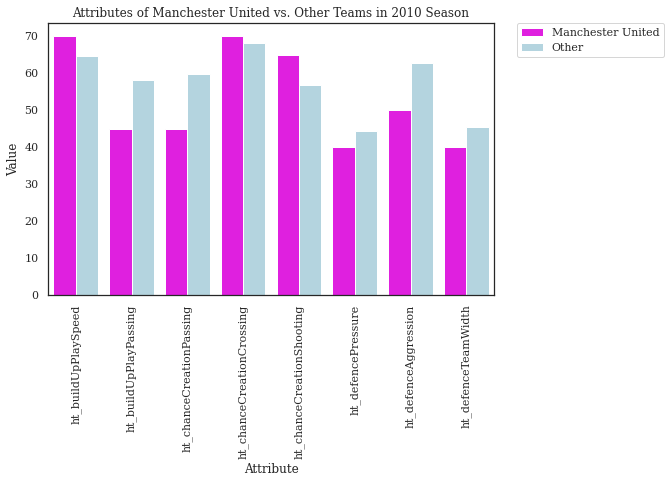

In [ ]:
#Plot team statistics for Manchester United against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
manu_2010_vis = pd.DataFrame(columns = vis_cols, data = [manu_2010, other_2010]).transpose().reset_index()[1:]
manu_2010_vis.columns = ['attribute', 'Manchester United', 'Other']

#convert into bar plot format
manu_2010_vis = manu_2010_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = manu_2010_vis, x='Attribute', y='Value', hue = 'Variable', palette=['magenta', 'lightblue'])

#add labels
plt.title('Attributes of Manchester United vs. Other Teams in 2010 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("manu-2010.png", bbox_inches='tight', dpi=300)
files.download("manu-2010.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

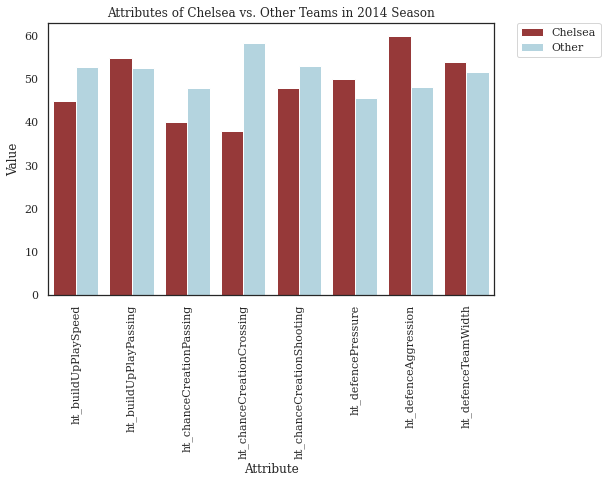

In [ ]:
#Plot team statistics for Chelsea against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
mc_2013_vis = pd.DataFrame(columns = vis_cols, data = [mc_2013, other_2013]).transpose().reset_index()[1:]
mc_2013_vis.columns = ['attribute', 'Chelsea', 'Other']

#convert into bar plot format
mc_2013_vis = mc_2013_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = mc_2013_vis, x='Attribute', y='Value', hue = 'Variable', palette=['brown', 'lightblue'])

#add labels
plt.title('Attributes of Chelsea vs. Other Teams in 2014 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("chelsea-2014.png", bbox_inches='tight', dpi=300)
files.download("chelsea-2014.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

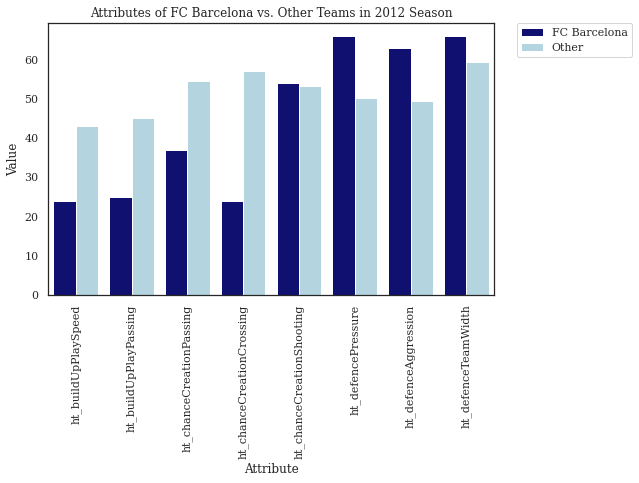

In [ ]:
#Plot team statistics for FC Barcelona against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
fcb_2012_vis = pd.DataFrame(columns = vis_cols, data = [fcb_2012, other_2012]).transpose().reset_index()[1:]
fcb_2012_vis.columns = ['attribute', 'FC Barcelona', 'Other']

#convert into bar plot format
fcb_2012_vis = fcb_2012_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = fcb_2012_vis, x='Attribute', y='Value', hue = 'Variable', palette=['navy', 'lightblue'])

#add labels
plt.title('Attributes of FC Barcelona vs. Other Teams in 2012 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("fcbarc-2012.png", bbox_inches='tight', dpi=300)
files.download("fcbarc-2012.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

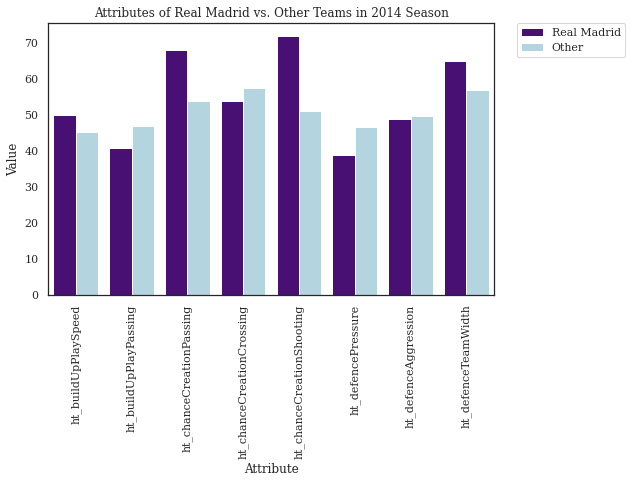

In [ ]:
#Plot team statistics for Real Madrid against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
rm_2014_vis = pd.DataFrame(columns = vis_cols, data = [rm_2014, other_2014]).transpose().reset_index()[1:]
rm_2014_vis.columns = ['attribute', 'Real Madrid', 'Other']

#convert into bar plot format
rm_2014_vis = rm_2014_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = rm_2014_vis, x='Attribute', y='Value', hue = 'Variable', palette=['indigo', 'lightblue'])

#add labels
plt.title('Attributes of Real Madrid vs. Other Teams in 2014 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("rm-2014.png", bbox_inches='tight', dpi=300)
files.download("rm-2014.png")

Wow, this isn't exactly what we would have expected! While the winning teams beat average (most times by a lot) on a few attributes, they aren't necessarily better than average on all. Some takeaways we can glean from this analysis:
*    Strong defensive skills in a team seem to be a decent indicator of the team's strength (Chelsea, FC Barcelona, and Real Madrid all significantly beat average on one or more defensive attributes).
*    Strong offensive skills – specifically, buildUpPlaySpeed and one of chanceCreationCrossing/Shooting may make up for weak defensive skills – to place a team in the top spot.

##What do the offensive/defensive statistics look like for the teams who have the most goals scored/conceded?

First, we want to find the teams with the most goals scored across all games for each season in the English and Spanish leagues, which we determined were more competitive from our previous visualizations. 

###Teams with the max goals scored for each season in the England Premier League and Spanish LaLiga
We start with finding the highest goal-scoring teams in a given season. To do this, we define a function called maxGoals and getGoalScorersAcrossSeason, ultimately getting the top scoring teams across all seasons.

In [ ]:
#given a dataframe of matches in a season, this function returns the x teams who have scored the most goals
def maxGoals(team_goal_df, x) :
  #sum of all goals scored by home and away teams (home_goal and away_goal columns)
  team_goal_df_home = team_goal_df.groupby(by=['home_team_api_id', 'ht_team_long_name', 'season']).sum().reset_index()[[
      'home_team_api_id', 'ht_team_long_name', 'home_team_goal', 'season']]
  team_goal_df_away = team_goal_df.groupby(by='away_team_api_id').sum().reset_index()[[
      'away_team_api_id', 'away_team_goal']]

  #merge to get every team's home AND away goals
  team_goal_combined = team_goal_df_home.merge(team_goal_df_away, left_on='home_team_api_id', right_on='away_team_api_id')
  team_goal_combined['total_goals'] = team_goal_combined['home_team_goal'] + team_goal_combined['away_team_goal']
  #sort by total goals scored
  team_goal_combined = team_goal_combined.sort_values(by='total_goals', ascending=False)

  #return the top X goalscoring teams
  return team_goal_combined[['ht_team_long_name', 'home_team_api_id', 'total_goals', 'season']].head(x)

In [ ]:
#given a list of dataframes, dfs, and the number of top goalscorers, x, to obtain each season, this 
#function outputs a dataframe that contains all of the top n goalscorers per season in a given league
def getGoalScorersAcrossSeason(dfs, x):
  scorers = []
  for season in dfs:
    scorers.append(maxGoals(season, x))
  return pd.concat(scorers)

In [ ]:
#get the teams with the most goals in every season for both leagues
englishScorers = getGoalScorersAcrossSeason(matchFrames_english, 1)
spanishScorers = getGoalScorersAcrossSeason(matchFrames_spanish, 1)

In [ ]:
englishScorers

,ht_team_long_name,home_team_api_id,total_goals,season
8,Liverpool,8650,77,2008/2009
1,Chelsea,8455,103,2009/2010
18,Manchester United,10260,78,2010/2011
1,Manchester City,8456,93,2011/2012
18,Manchester United,10260,86,2012/2013
2,Manchester City,8456,102,2013/2014
3,Manchester City,8456,83,2014/2015
2,Manchester City,8456,71,2015/2016


In [ ]:
spanishScorers

,ht_team_long_name,home_team_api_id,total_goals,season
9,FC Barcelona,8634,105,2008/2009
6,Real Madrid CF,8633,102,2009/2010
8,Real Madrid CF,8633,102,2010/2011
11,Real Madrid CF,8633,121,2011/2012
12,FC Barcelona,8634,115,2012/2013
10,Real Madrid CF,8633,104,2013/2014
10,Real Madrid CF,8633,118,2014/2015
12,FC Barcelona,8634,112,2015/2016


Let's see how the highest number of goals scored in a season has changed over time.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

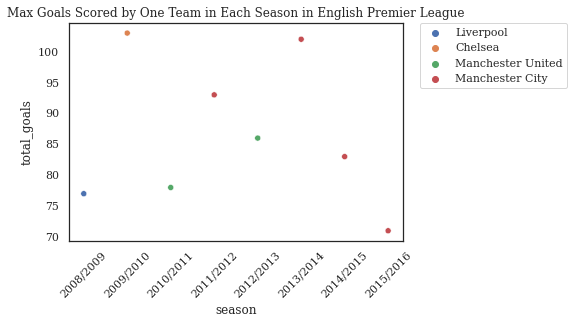

In [ ]:
#scatterplot of max goals by season in English Premier League
sns.scatterplot(data=englishScorers, x='season', y='total_goals', hue='ht_team_long_name').set(
    Title='Max Goals Scored by One Team in Each Season in English Premier League')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig("maxGoalsE.png", bbox_inches='tight', dpi=300)
files.download("maxGoalsE.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

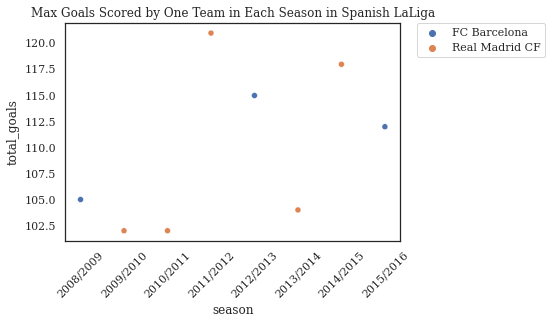

In [ ]:
#scatterplot of max goals by season in LaLiga
sns.scatterplot(data=spanishScorers, x='season', y='total_goals', hue='ht_team_long_name').set(
    Title='Max Goals Scored by One Team in Each Season in Spanish LaLiga')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig("maxGoalsS.png", bbox_inches='tight', dpi=300)
files.download("maxGoalsS.png")

From these plots we see that English Premier League has four different teams that have scored the most goals each season from 2008-2016 compared to Spanish LaLiga whose top goal scorer fluctuated between only two teams between 2008-2016. We also see that the total goals was much higher among the Spanish teams compared to English teams across the board, with the minimum number of max goals scored as 71 and 102, respectively. This could indicate that the Spanish league has less competitive teams between each other, but may have a few teams that perform better overall. 

Next, we'll plot the team and player attributes of some of these top scorers. Specifically, we'll look at:


*   Chelsea in the 2009/2010 season
*   Real Madrid in the 2011/2012 season



In [ ]:
#Note we'll reuse some of the code from the previous section

#choose the team and player attributes we want to highlight
team_attr = ['ht_team_long_name', 'ht_buildUpPlaySpeed', 'ht_buildUpPlayPassing', 'ht_chanceCreationPassing',
             'ht_chanceCreationCrossing', 'ht_chanceCreationShooting']
player_attr = ['hp_avg_crossing', 'hp_avg_finishing', 'hp_avg_heading_accuracy', 
               'hp_avg_curve', 'hp_avg_free_kick_accuracy', 'hp_avg_shot_power']
#group the lists together for visualization
vis_cols = team_attr + player_attr

#get the statistics for each team in the given season, and the average of the other teams in the given season

#statistics for Chelsea
engl_2009 = matchFrames_english[1]
#team-wide stats
ch_team_2009 = engl_2009[engl_2009['home_team_api_id'] == 8455][team_attr].iloc[0].tolist()
#player-avg stats
ch_pl_2009 = engl_2009[engl_2009['home_team_api_id'] == 8455][player_attr].mean().tolist()
#stats to plot!
ch_2009 = ch_team_2009 + ch_pl_2009
#other team stats
other_2009 = engl_2009[engl_2009['home_team_api_id'] != 8455]
other_2009 = ['other'] + engl_2009.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()

#statistics for Real Madrid
span_2011 = matchFrames_spanish[3]
#team-wide stats
rm_team_2011 = span_2011[span_2011['home_team_api_id'] == 8633][team_attr].iloc[0].tolist()
#player-avg stats
rm_pl_2011 = span_2011[span_2011['home_team_api_id'] == 8633][player_attr].mean().tolist()
#stats to plot!
rm_2011 = rm_team_2011 + rm_pl_2011
#other team stats
other_2011 = span_2011[span_2011['home_team_api_id'] != 8633]
other_2011 = ['other'] + span_2011.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()


<ipython-input-532-d5e7a5f2b5e6>:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2009 = ['other'] + engl_2009.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()
<ipython-input-532-d5e7a5f2b5e6>:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2011 = ['other'] + span_2011.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

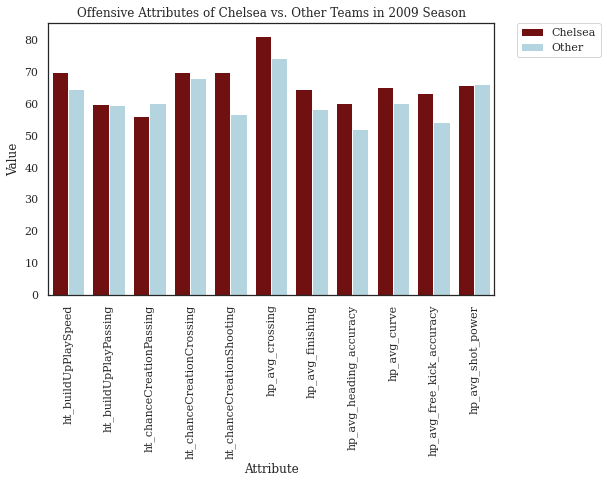

In [ ]:
#Plot team statistics for Chelsea against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
ch_2009_vis = pd.DataFrame(columns = vis_cols, data = [ch_2009, other_2009]).transpose().reset_index()[1:]
ch_2009_vis.columns = ['attribute', 'Chelsea', 'Other']

#convert into bar plot format
ch_2009_vis = ch_2009_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = ch_2009_vis, x='Attribute', y='Value', hue = 'Variable', palette=['maroon', 'lightblue'])

#add labels
plt.title('Offensive Attributes of Chelsea vs. Other Teams in 2009 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("chelsea-09.png", bbox_inches='tight', dpi=300)
files.download("chelsea-09.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

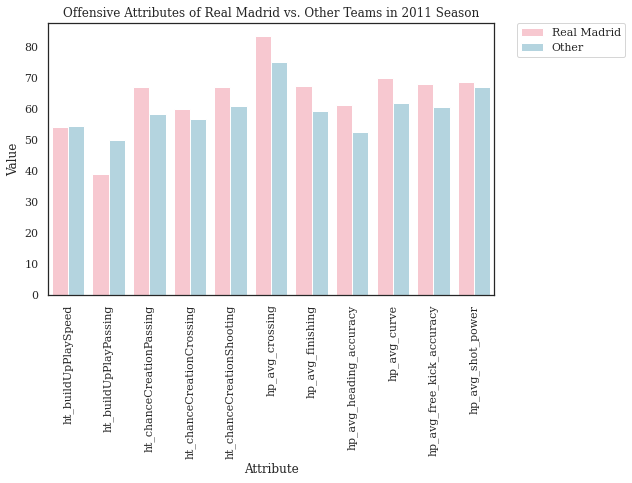

In [ ]:
#Plot team statistics for Real Madrid against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
rm_2011_vis = pd.DataFrame(columns = vis_cols, data = [rm_2011, other_2011]).transpose().reset_index()[1:]
rm_2011_vis.columns = ['attribute', 'Real Madrid', 'Other']

#convert into bar plot format
rm_2011_vis = rm_2011_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = rm_2011_vis, x='Attribute', y='Value', hue = 'Variable', palette=['pink', 'lightblue'])

#add labels
plt.title('Offensive Attributes of Real Madrid vs. Other Teams in 2011 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("rm-11.png", bbox_inches='tight', dpi=300)
files.download("rm-11.png")

Super cool! This is pretty much exactly what we expected – these top scoring teams are above average on pretty much every offensive attribute.

###Teams with the minimum conceded goals during each season in the England Premier League and Spanish LaLiga

Next we will look at the teams who conceded the least goals during their seasons in the English and Spanish leagues. We will start by defining the minConceded function, and then applying it over our season dataframes

In [ ]:
#given a dataframe of matches in a season, this function returns the x teams who have conceded the least goals
def minConceded(team_goal_df, x) :
  #sum of all goals scored by home and away teams (home_goal and away_goal columns)
  team_goal_df_home = team_goal_df.groupby(by=['home_team_api_id', 'ht_team_long_name', 'season']).sum().reset_index()[[
      'home_team_api_id', 'ht_team_long_name', 'away_team_goal', 'season']]
  team_goal_df_away = team_goal_df.groupby(by='away_team_api_id').sum().reset_index()[[
      'away_team_api_id', 'home_team_goal']]

  #merge to get every team's home AND away conceded goals
  team_goal_combined = team_goal_df_home.merge(team_goal_df_away, left_on='home_team_api_id', right_on='away_team_api_id')
  team_goal_combined['total_goals'] = team_goal_combined['home_team_goal'] + team_goal_combined['away_team_goal']
  #sort by least goals conceded
  team_goal_combined = team_goal_combined.sort_values(by='total_goals', ascending=True)

  #return the top X goalscoring teams
  return team_goal_combined[['ht_team_long_name', 'home_team_api_id', 'total_goals', 'season']].head(x)

In [ ]:
#given a list of dataframes, dfs, and the number of top goalblockers, x, to obtain each season, this 
#function outputs a dataframe that contains all of the top n goalblockers per season in a given league
def getGoalBlockersAcrossSeason(dfs, x):
  blockers = []
  for season in dfs:
    blockers.append(minConceded(season, x))
  return pd.concat(blockers)

In [ ]:
#get the teams with the least goals conceded in every season for both leagues
englishBlockers = getGoalBlockersAcrossSeason(matchFrames_english, 1)
spanishBlockers = getGoalBlockersAcrossSeason(matchFrames_spanish, 1)

In [ ]:
englishBlockers

,ht_team_long_name,home_team_api_id,total_goals,season
0,Chelsea,8455,24,2008/2009
19,Manchester United,10260,28,2009/2010
0,Chelsea,8455,33,2010/2011
1,Manchester City,8456,29,2011/2012
1,Manchester City,8456,34,2012/2013
1,Chelsea,8455,27,2013/2014
2,Chelsea,8455,32,2014/2015
5,Tottenham Hotspur,8586,35,2015/2016


In [ ]:
spanishBlockers

,ht_team_long_name,home_team_api_id,total_goals,season
9,FC Barcelona,8634,35,2008/2009
7,FC Barcelona,8634,24,2009/2010
9,FC Barcelona,8634,21,2010/2011
12,FC Barcelona,8634,29,2011/2012
16,Atlético Madrid,9906,31,2012/2013
14,Atlético Madrid,9906,26,2013/2014
11,FC Barcelona,8634,21,2014/2015
16,Atlético Madrid,9906,18,2015/2016


[link text](https://)To see how these goal metrics have changed over time, let's plot the data for both leagues and see what comparisons we can draw.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

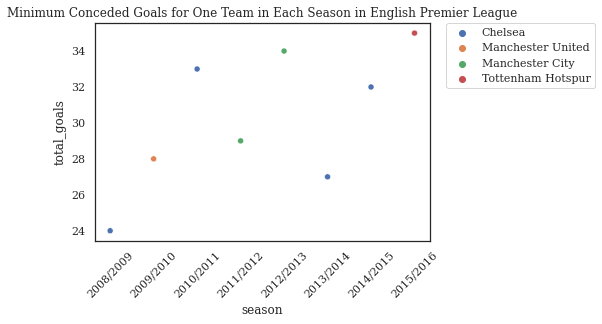

In [ ]:
#scatterplot of least goals conceded by season in English Premier League
sns.scatterplot(data=englishBlockers, x='season', y='total_goals', hue='ht_team_long_name').set(
    Title='Minimum Conceded Goals for One Team in Each Season in English Premier League')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig("mingoalsE.png", bbox_inches='tight', dpi=300)
files.download("mingoalsE.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

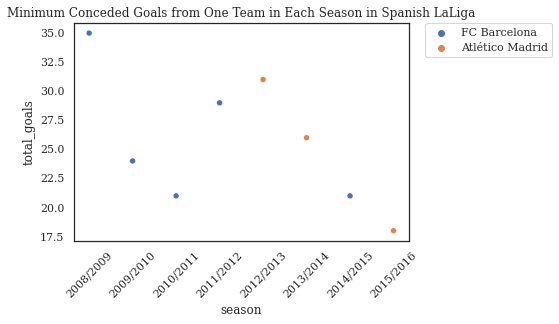

In [ ]:
#scatterplot of least goals conceded by season in English Premier League
sns.scatterplot(data=spanishBlockers, x='season', y='total_goals', hue='ht_team_long_name').set(
    Title='Minimum Conceded Goals from One Team in Each Season in Spanish LaLiga')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig("mingoalsS.png", bbox_inches='tight', dpi=300)
files.download("mingoalsS.png")

An interesting note here is that the top goal scoring teams from the Spanish league were FC Barcelona and Real Madrid CF, while the teams with the minimum conceded goals in this league were consistently FC Barcelona and Atletico Madrid across the 8 seasons. In the English league, the top goal scoring teams were consistently Liverpool, Chelsea, Manchester United, and Manchester City, while the teams with the least conceced goals were Chelsea, Manchester United, Manchester City, and Tottenham Hotspur. This indicates that Chelsea, Manchester United, and Manchester City are both offensively and defensively strong since they scored the most goals and gave up the least. This provides good insight for future modeling because the team characteristics among these three teams could be good predictors for success in a match. 

Next, we'll plot the team and player attributes of some of these minimum goal conceders. Specifically, we'll look at:


*   Tottenham Hotspur in the 2015/2016 season
*   Atletico Madrid in the 2012/2013 season

In [ ]:
#Note we'll reuse some of the code from the previous section

#choose the team and player attributes we want to highlight
team_attr = ['ht_team_long_name', 'ht_defencePressure', 'ht_defenceAggression', 
             'ht_defenceTeamWidth']
player_attr = ['hp_avg_jumping', 'hp_avg_strength', 'hp_avg_interceptions','hp_avg_positioning', 
               'hp_avg_penalties', 'hp_avg_marking', 'hp_avg_gk_overall']
#group the lists together for visualization
vis_cols = team_attr + player_attr

#get the statistics for each team in the given season, and the average of the other teams in the given season

#statistics for Chelsea
engl_2015 = matchFrames_english[7]
#team-wide stats
th_team_2015 = engl_2015[engl_2015['home_team_api_id'] == 8586][team_attr].iloc[0].tolist()
#player-avg stats
th_pl_2015 = engl_2015[engl_2015['home_team_api_id'] == 8586][player_attr].mean().tolist()
#stats to plot!
th_2015 = th_team_2015 + th_pl_2015
#other team stats
other_2015 = engl_2015[engl_2015['home_team_api_id'] != 8586]
other_2015 = ['other'] + engl_2015.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()

#statistics for Real Madrid
span_2012 = matchFrames_spanish[4]
#team-wide stats
am_team_2012 = span_2012[span_2012['home_team_api_id'] == 9906][team_attr].iloc[0].tolist()
#player-avg stats
am_pl_2012 = span_2012[span_2012['home_team_api_id'] == 9906][player_attr].mean().tolist()
#stats to plot!
am_2012 = am_team_2012 + am_pl_2012
#other team stats
other_2012 = span_2012[span_2012['home_team_api_id'] != 9906]
other_2012 = ['other'] + span_2012.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()

<ipython-input-616-d6d42645cb4b>:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2015 = ['other'] + engl_2015.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()
<ipython-input-616-d6d42645cb4b>:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  other_2012 = ['other'] + span_2012.drop_duplicates('home_team_api_id')[vis_cols].mean().tolist()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

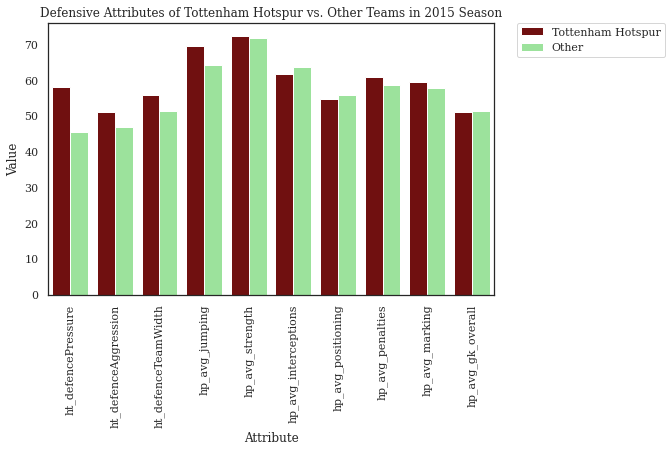

In [ ]:
#Plot team statistics for Tottenham Hotspur against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
th_2015_vis = pd.DataFrame(columns = vis_cols, data = [th_2015, other_2015]).transpose().reset_index()[1:]
th_2015_vis.columns = ['attribute', 'Tottenham Hotspur', 'Other']

#convert into bar plot format
th_2015_vis = th_2015_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = th_2015_vis, x='Attribute', y='Value', hue = 'Variable', palette=['maroon', 'lightgreen'])

#add labels
plt.title('Defensive Attributes of Tottenham Hotspur vs. Other Teams in 2015 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("th-2015.png", bbox_inches='tight', dpi=300)
files.download("th-2015.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

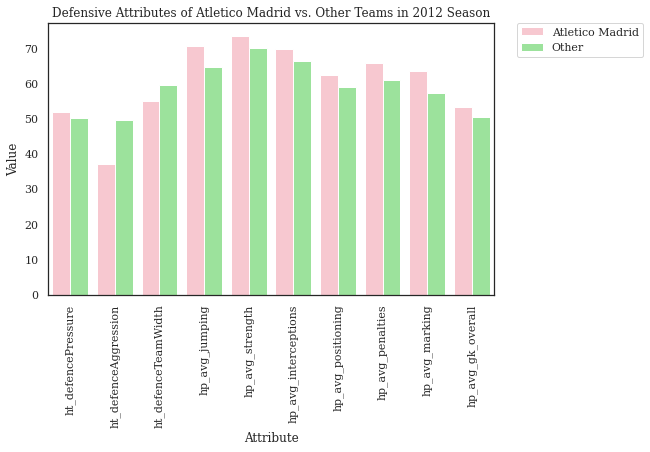

In [ ]:
#Plot team statistics for Atletico Madrid against other teams in season
fig, ax = plt.subplots(figsize=(8, 5))
am_2012_vis = pd.DataFrame(columns = vis_cols, data = [am_2012, other_2012]).transpose().reset_index()[1:]
am_2012_vis.columns = ['attribute', 'Atletico Madrid', 'Other']

#convert into bar plot format
am_2012_vis = am_2012_vis.melt(id_vars='attribute').rename(columns=str.title)
sns.barplot(data = am_2012_vis, x='Attribute', y='Value', hue = 'Variable', palette=['pink', 'lightgreen'])

#add labels
plt.title('Defensive Attributes of Atletico Madrid vs. Other Teams in 2012 Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)

plt.savefig("am-2012.png", bbox_inches='tight', dpi=300)
files.download("am-2012.png")

Again, this is awesome! This is pretty much exactly what we expected – these teams who conceded the last goals are above average on pretty much every defensive attribute.

##Have leagues become more competitive over time?

To determine if leagues have become more competitive over time, we will first take the grouped_matches_visualization dataframe to get the data from each match, and then group by league and season in order to see how league features have changed over time from 2008-2016 within the matches dataframe.

In [ ]:
#get matches grouped by league and season
grouped_matches_leagues_seasons = final_matches_visualization.groupby(['league_name', 'season']).mean().reset_index()

First we will look at how the average dribbling for home players in a match has changed over time across the leagues

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

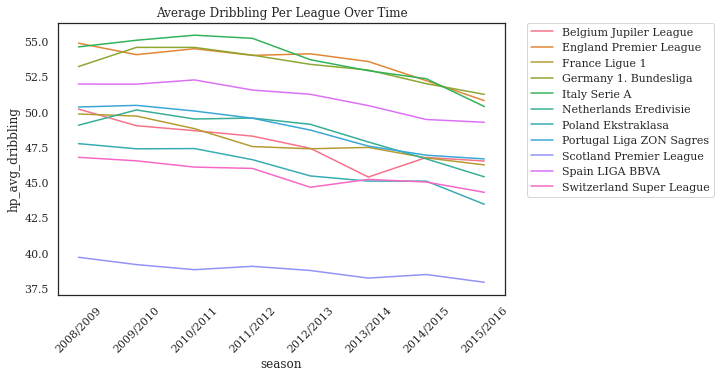

In [ ]:
#plot average dribbling as a function of time (season)
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=grouped_matches_leagues_seasons, x='season', y='hp_avg_dribbling', hue='league_name').set(Title='Average Dribbling Per League Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("ldribbling.png", bbox_inches='tight', dpi=300)
files.download("ldribbling.png")

Interestingly, the average dribbling per player in a match seems to be on a downward trend for each league. Perhaps as game strategy has evolved over time and with the speed of the game, other factors such as passing have become more important than dribbling alone. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

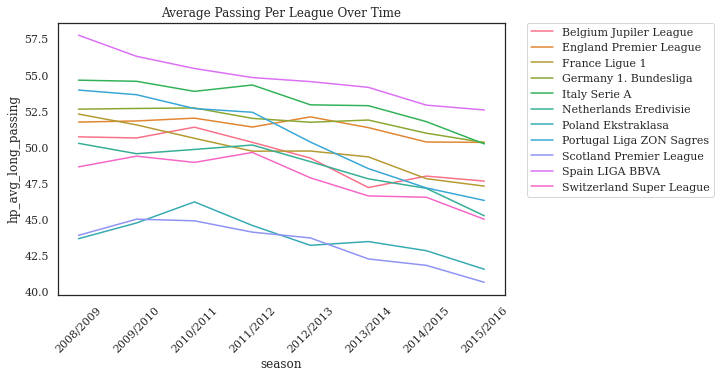

In [ ]:
#plot average passing as a function of time (season)
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=grouped_matches_leagues_seasons, x='season', y='hp_avg_long_passing', hue='league_name').set(Title='Average Passing Per League Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("lpassing.png", bbox_inches='tight', dpi=300)
files.download("lpassing.png")

We see that there also seems to be a downward trend for the player average passing scores for each league across the eight seasons. Perhaps this indicates that team success has become less dependent on individual player skills and more dependent on the team's ratings as a whole. We will investigate the player average ratings per league, and then move on to some team characteristics to see if we can find any trends that disrupt this downward pattern

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

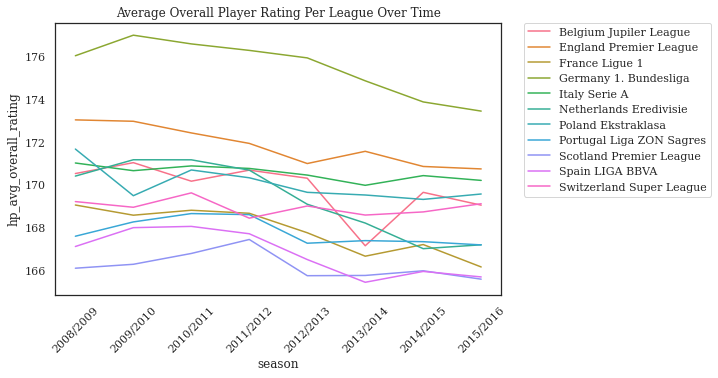

In [ ]:
#plot average player rating as a function of time (season)
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=grouped_matches_leagues_seasons, x='season', y='hp_avg_overall_rating', hue='league_name').set(Title='Average Overall Player Rating Per League Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("lrating.png", bbox_inches='tight', dpi=300)
files.download("lrating.png")

The average player rating per league per season does not follow as strict of a downward trend as with the other features we tested previously. It could be that the rating systems have slightly changed over times, as compared to "the greats" in the early 2000s. Also, this may indicate that there is a lot of variability in average player overall ratings per league. Next, we will see how some team attributes have trended over time for each league.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

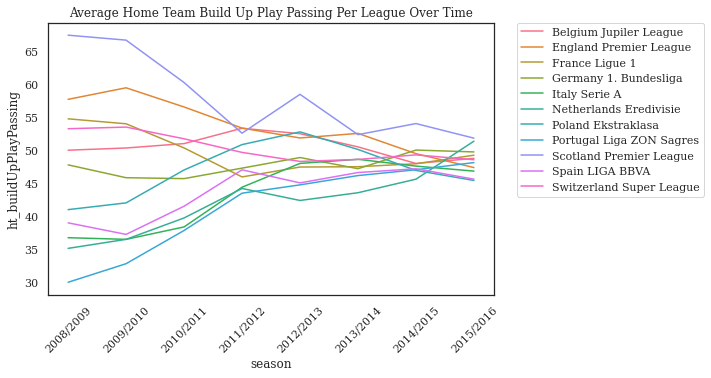

In [ ]:
#plot average build up play passing as a function of time (season)
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=grouped_matches_leagues_seasons, x='season', y='ht_buildUpPlayPassing', hue='league_name').set(Title='Average Home Team Build Up Play Passing Per League Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("lbpassing.png", bbox_inches='tight', dpi=300)
files.download("lbpassing.png")

It seems that the team average build up play passing per league has converged over time. This is an interesting contrast to the downward trend of the average passing score for each player across the matches in each league. This could mean that while individual player passing skills have gone down, the leagues themselves have adopted more of an even playing field with passing skills. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

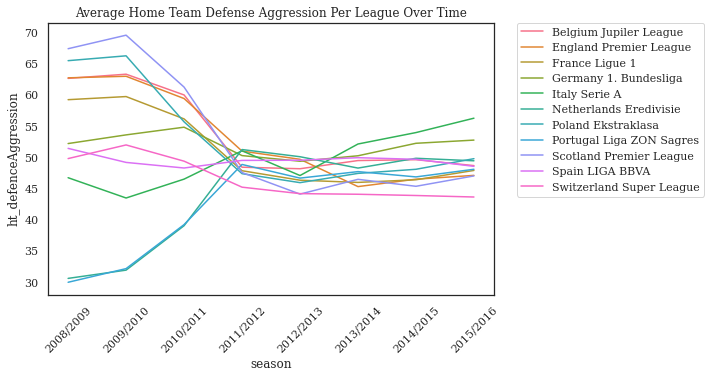

In [ ]:
#plot average defence aggression as a function of time (season)
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=grouped_matches_leagues_seasons, x='season', y='ht_defenceAggression', hue='league_name').set(Title='Average Home Team Defense Aggression Per League Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("ldefenseagg.png", bbox_inches='tight', dpi=300)
files.download("ldefenseagg.png")

Here we see an intersting trend in the team defense aggression over time per league. The defence aggression score converges around 2012, and then begins to separate in 2013, but the scores are still much closer than before the bottleneck in 2011/2012. This could speak to the evolution of the professional game with rule changes and competitive atmosphere. 

##How have the winningest teams changed over time in the England Premier League and Spanish LaLiga?

Now we want to see how the winninges teams have evolved across the eight seasons for each league. We will use the getWinningAcrossSeason function defined earlier to make two dataframes, one with the three winningest teams from each season in the England league, and another for those in the Spanish league. 

In [ ]:
#make top three winningest teams per season dataframe
wins_eng = getWinningAcrossSeason(matchFrames_english, 3)
wins_span = getWinningAcrossSeason(matchFrames_spanish, 3)

To visualize the winningest teams per league per season, we will take these dataframes and plot them for each league. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

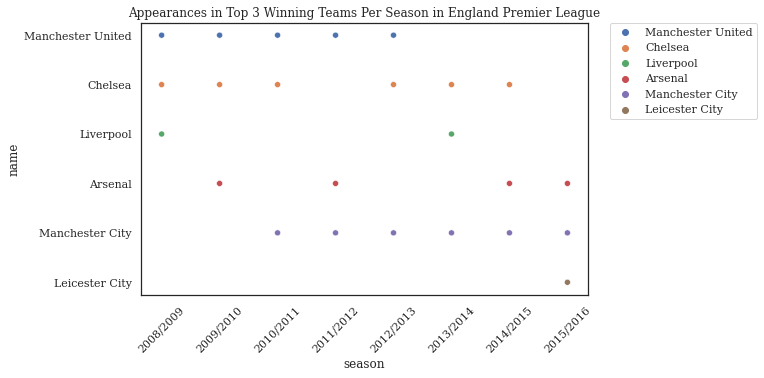

In [ ]:
#plot appearances in top 3 teams across seasons for English PremierLeague
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=wins_eng, x='season', y='name', hue='name').set(
    Title='Appearances in Top 3 Winning Teams Per Season in England Premier League')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("winnersE.png", bbox_inches='tight', dpi=300)
files.download("winnersE.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

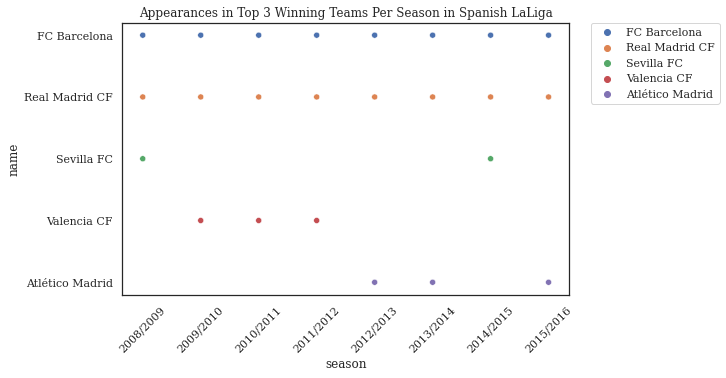

In [ ]:
#plot appearances in top 3 teams across seasons for Spanish LaLiga
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=wins_span, x='season', y='name', hue='name').set(
    Title='Appearances in Top 3 Winning Teams Per Season in Spanish LaLiga')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

plt.savefig("winnersS.png", bbox_inches='tight', dpi=300)
files.download("winnersS.png")

Based on these visualizations, we see that Real Madrid CF and FC Barcelona have been in the top 3 wins for the Spanish LaLiga from 2008-2016. In previous exploratory data analysis, we saw that these two teams also had the max goals scored in the Spanish league every year of the dataset as well. This indicates that there may be some correlation betwen the max goal scoring team and the top 3 winningest teams for that season. Finally, these graphs are especially cool because we can visualize how the power in these leagues has shifted over seasons! For example, in the Premier League we see that Manchester United perhaps lost dominance sometime around 2012, which is the same time that Manchester City started to dominate.

# Modeling
## Regression: Predicting the Goal Difference of a Game
Now, we can get to modeling. We can start with simple linear regression models that will try to predict the score difference in a given match.

We'll begin with a linear regression model to predict **goal_difference**. This is the entry in the DataFrame representing the difference in the number of goals between the home team and the away team.

First, we remove all of the columns that directly indicate the result we are trying to predict, like **home_team_goal** and **away_team_goal**, which are directly summed to create the target, **goal_difference**. We also remove **home_win**, because it is represents the result of the game, which negates the point of the regression!

In [ ]:
# First, we remove all of the columns that directly indicate the result we are trying to predict
features = final_matches_modeling.drop(['home_team_goal', 'away_team_goal', 'home_win', 'goal_difference'], axis=1)

Next, we'll one-hot encode the important dates, and remove the date columns from the dataframe. We add a year, month, and day column for each of the important dates, and then drop the original date column from the features dataframe.

In [ ]:
#function to one-hot encode important dates
def encode_date(df, col, format):
  df[col] = pd.to_datetime(df[col], format=format)
  df[col+'_year'] = df[col].apply(lambda x: x.year)
  df[col+'_month'] = df[col].apply(lambda x: x.month)
  df[col+'_day'] = df[col].apply(lambda x: x.day)

encode_date(features, 'date', '%Y-%m-%d %H:%M:%S')
encode_date(features, 'team_stat_date', '%Y-%m-%d %H:%M:%S')

features = features.drop(['date', 'team_stat_date', 'ht_date', 'at_date'], axis=1)


Then, we define the target of our model, the goal difference.

In [ ]:
target = final_matches_modeling['goal_difference']

Now we can split our data into train and test sets. We have decided to use a test set size of 20% of the total data. We are using a random seed in order to produce exactly repeatable results.

In [ ]:
#set seed and split into training/test data, with a test size of 20%
seed = 545
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=seed)

## Linear Regression
Let's train our Linear Regression model. We will use the scikit-learn LinearRegression model, fitting it to our training data, and then predicting on our test data. We also get the $R^2$ score.

In [ ]:
#run linear regression model and get R2 score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)

y_pred = linear_reg.predict(x_test)

linear_reg_score = linear_reg.score(x_test, y_test)
linear_reg_MSE = metrics.mean_squared_error(y_test, y_pred)

Let's take a look at the $R^2$ score of our model.

In [ ]:
linear_reg_score

0.21667396381525572

In [ ]:
linear_reg_MSE

2.5299445223133237

Initially, we were surprised to see such a low $R^2$ value, that in some scenarios would indicate very little correlation. So, we decided to plot the predicted score difference vs. the actual score difference, to see if there was any trend at all. 

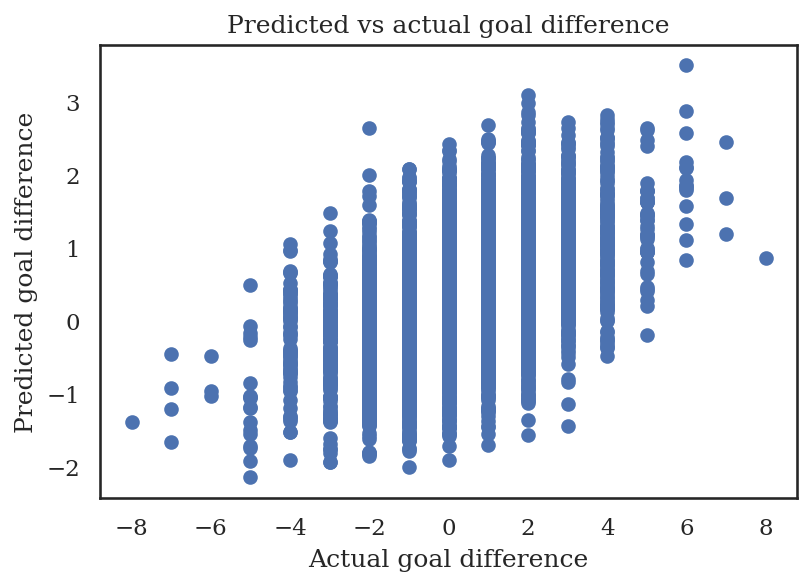

In [ ]:
#plot actual vs. predicted
plt.figure(dpi = 150)
plt.plot(y_test, y_pred, 'o')
plt.title('Predicted vs actual goal difference')
plt.xlabel('Actual goal difference')
plt.ylabel('Predicted goal difference')
plt.show()


From this plot, we were better able to understand what our Linear Regression model was doing. 

The first important thing to note, is that almost 97% of the outcomes in our training set fall between -3 and 4, as shown below.

In [ ]:
print(f'{round(100 * len([x for x in y_train if -3 <= x <= 4]) / len(y_train), 2)}% of the training goal differences fall between -3 and 4 (inclusive.)')

96.99% of the training goal differences fall between -3 and 4 (inclusive.)


For this reason, the model rarely (if ever) guesses outside of those bounds. We should also note that there clearly is an upward trend in the plot above. As the actual goal difference increases, the predicted goal difference (roughly) increases as well.

The reason for the $R^2$ value that we initally considered to be relatively low is simply how big the variance is in the real data. In soccer matches, and sports in general, it is notoriously difficult to predict who will win any given game. Regardless of how much knowledge you have about a team, upsets happen all the time. And the linear model is not even classifying which team won, it is trying to predict the difference in goals scored in the game. With all of this considered, we realized the $R^2$ value of around 0.2 actually does indicate some learning by our model.

We decided (for a bit of fun) to compare this to a baseline model of random guessing, as if by a person with no knowledge of the two teams playing. So, we 'trained' a model to randomly guess a goal difference between -3 and 4.

In [ ]:
#baseline model to predict goal difference
import random
from sklearn.metrics import r2_score

random_model = [random.choice(range(-3, 5)) for _ in y_test]
r2_score(y_test, random_model)

-1.5937473315896011

This model, of course, does not perform very well. In fact, a negative $R^2$ score indicates that it is performing worse than just predicting the mean every time. However, it does prove some learning has been done by our Linear Regressor, to achieve an $R^2$ value of around 0.2.

## PCA
As it stands, our model has a lot of features (74!) We decided to use Principal Component Analysis to reduce the number of dimensions of our features, to see if this would improve the success of our linear regression model. First, we used StandardScaler to address the scale invariance of PCA.



In [ ]:
#run standard scaler to standardize data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

We then fit PCA to the scaled data. We plot the cumulative explained variance ratio, as we did in homework 4, in order to find the ideal number of Principal Components to choose

In [ ]:
#fit PCA to our training data
pca = PCA(n_components=x_train_scaled.shape[1])
pca.fit(x_train_scaled)

PCA(n_components=74)

We will plot the cumulative explained variance ratio against the number of components, with a threshold of 90%, to decide the number of components to keep.

In [ ]:
#get cumulative explained variance ratio
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = [explained_variance_ratios[0]]
for index, value in enumerate(explained_variance_ratios[1:]):
  cum_evr.append(value + cum_evr[index])

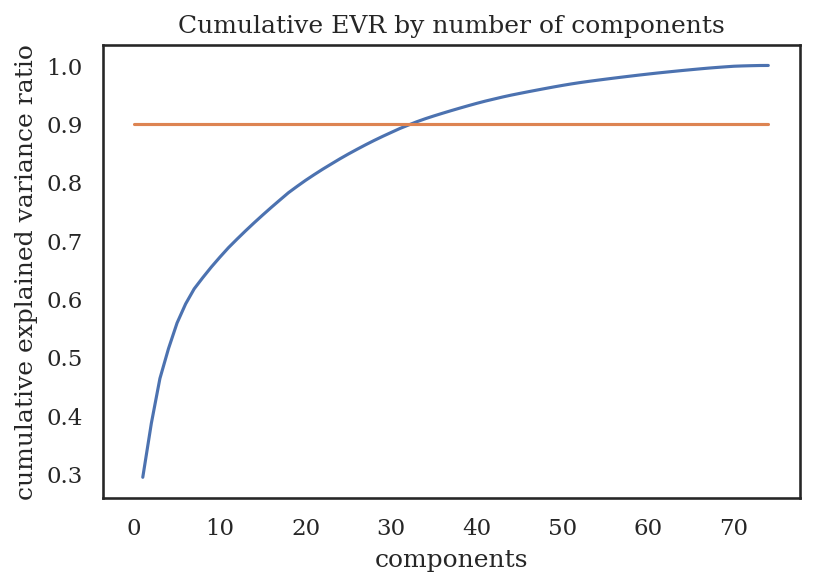

In [ ]:
#plot cumulative explained variance ratio
plt.figure(dpi = 150)
data = pd.DataFrame(cum_evr, columns=['cumulative explained variance ratio']).reset_index()
data['components'] = data['index'].apply(lambda x: x + 1)
sns.lineplot(data=data, x='components', y='cumulative explained variance ratio')
sns.lineplot(data = [0.9] * 75)
plt.title('Cumulative EVR by number of components')
plt.show()

Using these results, keeping 33 components explains over 90% of total variance in the dataset. We will use this as our number of components for PCA. We can now fit this PCA to our scaled training data, and use it to transform our testing data.

In [ ]:
#fit PCA with 33 components
pca = PCA(n_components=33)
pca_x_train = pca.fit_transform(x_train_scaled)

pca_x_test = pca.transform(x_test_scaled)

Now, we can train a new linear model on our transformed training data, and use it to predict on our transformed test data. We save the $R^2$ score as `linear_pca_score`.

In [ ]:
#train linear regression with PCA
linear_pca = LinearRegression()
linear_pca.fit(pca_x_train, y_train)

y_pred = linear_pca.predict(pca_x_test)

linear_reg_score_pca = linear_pca.score(pca_x_test, y_test)

Let's take a look at that $R^2$ score.

In [ ]:
linear_reg_score_pca

0.19373795086642398

It seems that with PCA, the model performed similarly, although slightly worse, than the linear regression model without PCA.

## Regularized Models
Next, we decided to use two regularized models, Lasso and Ridge, to try to predict the goal difference. We are trying these regularized models in order to focus the classifier on the most important contributing features.

In [ ]:
from sklearn.linear_model import Ridge, Lasso

### Ridge Model
We trained a Ridge model using an alpha value of 0.1.

In [ ]:
#train and predict with a ridge-regularized model
ridge = Ridge(alpha = 0.1)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
ridge_score = ridge.score(x_test, y_test)

Let's see the $R^2$ score.

In [ ]:
ridge_score

0.21667392133693497

That's pretty similar to our linear regression $R^2$ score!

In [ ]:
linear_reg_score - ridge_score 

4.2478320749772536e-08

The Ridge model's $R^2$ value is about 0.00000004 lower, meaning our Ridge model and initial Linear Regression model are *very* similar.

### Lasso Model
Now let's train a Lasso model, and look at it's $R^2$ score!

In [ ]:
#train and predict with a lasso-regularized model
lasso = Lasso(alpha = 0.1)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
lasso_score = lasso.score(x_test, y_test)

In [ ]:
lasso_score

0.2153969635722165

This again is very similar to our initial Linear Regression model, meaning they performed similarly well. We can also try creating Lasso and Ridge models using our PCA-transformed data.

In [ ]:
#train and predict with ridge-regularized model AND PCA
ridge_pca = Ridge(alpha = 0.1)
ridge_pca.fit(pca_x_train, y_train)
y_pred = ridge_pca.predict(pca_x_test)
ridge_score_pca = ridge_pca.score(pca_x_test, y_test)
ridge_score_pca

0.19373795898709922

In [ ]:
#train and predict with lasso-regularized model AND PCA
lasso_pca = Lasso(alpha=0.1)
lasso_pca.fit(pca_x_train, y_train)
y_pred = lasso_pca.predict(pca_x_test)
lasso_score_pca = lasso_pca.score(pca_x_test, y_test)
lasso_score_pca

0.18561505098053588

It seems that most of these models perform very similarly. Let's plot their $R^2$ values.

In [ ]:
regression_results_df = pd.DataFrame([
              ['Linear Regression', linear_reg_score_pca, True],
              ['Linear Regression', linear_reg_score, False],
              ['Ridge Regression', ridge_score_pca, True],
              ['Ridge Regression', ridge_score, False],
              ['Lasso Regression', lasso_score_pca, True],
              ['Lasso Regression', lasso_score, False]], columns=['Regression Type', 'Score', 'Used PCA'])

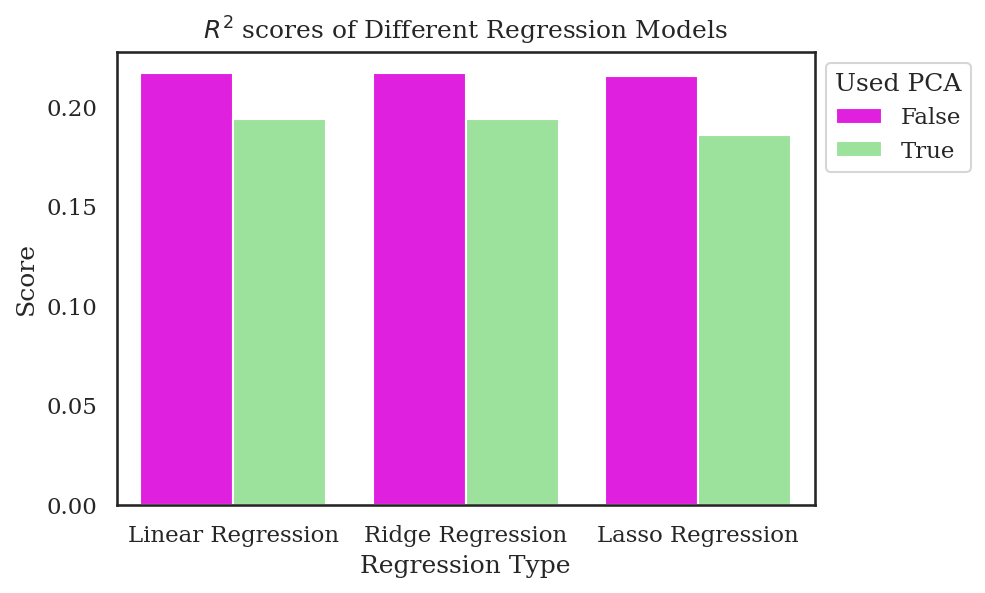

In [ ]:
plt.figure(dpi = 150)
ax = sns.barplot(data=regression_results_df, x='Regression Type', y='Score', hue='Used PCA', palette = ['magenta', 'lightgreen'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('$R^2$ scores of Different Regression Models')
plt.show()

Linear Regression without PCA performed best in the task of predicting the goal difference between two teams in a soccer match. Ridge Regression and Lasso Regression without PCA followed closely behind. PCA slightly decreased the $R^2$ value of each model.

So why did this happen? Why did Linear Regression perform most strongly?
PCA, along with regularization methods like Lasso and Ridge, are used to combat multicollinearity. However, during data cleaning, our group did a lot to ensure very little multicollinearity, including combining features that showed strong correlations. It is possible that the remaining features do not have strong multicollinearity, which is why reducing the number of features or introducing regularization does not have a strong effect on the success of the model on test data.

## Classification: Predicting Who Won!
In the regression section, our models were trying to predict the goal difference of a game given information about the two teams. This is, admittedly, a very difficult problem to solve, as a result of the high variance in the data. Let's try solve a more simple, but equally interesting, problem: classifying who won the match.

For this problem, we will use the `home_win` column as our label for classification. This column has a value of 1 if the home team won, 0 if there was a draw, and -1 if the home team lost.

In [ ]:
result = final_matches_modeling['home_win']

First, let's see what percent of matches end in a draw, win, and loss for the home team.

In [ ]:
#get the drawn/win/loss distribution of matches for the home team
def get_percentage(df, col_name, val_to_match):
  return 100 * len(df[df[col_name] == val_to_match]) / len(df)

In [ ]:
percentage_draws = get_percentage(final_matches_modeling, 'home_win', 0)
percentage_home_wins = get_percentage(final_matches_modeling, 'home_win', 1)
percentage_home_losses = get_percentage(final_matches_modeling, 'home_win', -1)
print(f'Of our data, {round(percentage_draws)}% of matches ended in a draw, the home team won in {round(percentage_home_wins)}% of matches, and the home team lost in {round(percentage_home_losses)}% of matches')

Of our data, 25% of matches ended in a draw, the home team won in 46% of matches, and the home team lost in 29% of matches


This means that just by predicting that each match is a home team win, we can achieve an accuracy of 46%. So, let's shoot for a value higher than that.

First, we'll split up our data, saving 20% for testing, and using a seed to achieve exactly repeatable results. We will also use PCA to reduce the number of features, as the logistic regression model reaches the maximum number of iterations if we do not.

In [ ]:
#split up our data into test/train with a test size of 20%
x_train, x_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 545)

In [ ]:
#run standard scaler and PCA on our match data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
pca = PCA(n_components=33)
pca_x_train = pca.fit_transform(x_train_scaled)
pca_x_test = pca.transform(x_test_scaled)

 ## Logistic Regression
 We will use a Logistic Regression model as our classifier. We initialize the model, fit it to our training data, and get the accuracy.

In [ ]:
#train and predict with a logistic regression classifier AND PCA
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(pca_x_train, y_train)

y_pred = log_reg.predict(pca_x_test)

log_reg_accuracy = log_reg.score(pca_x_test, y_test)

Let's take a look at the accuracy of our Logistic Regression classifier.

In [ ]:
log_reg_accuracy

0.5320932134096484

Wow! A 53% accuracy! This is much better than the control, guessing home win every time, which would yield a 46% accuracy. We can also compare this to a random classifier, which randomly guesses the outcome using the probabilities of a win, draw, or loss.

In [ ]:
#create a random classifier for our matches
def generate_rand_outcome():
  rand = random.random()
  if rand <= 0.29:
    return -1
  if rand <= 0.54:
    return 0
  return 1

random_classifier_results = [generate_rand_outcome() for _ in y_test]
random_classifier_accuracy = sum([x == y for x, y in zip(random_classifier_results, y_test)]) / len(y_test)

In [ ]:
random_classifier_accuracy

0.356909239574816

Clearly, our logistic regression model performs much better than random or controlled guessing! We can also take a look at the model's confusion matrix, to see if there's anything we can learn from it.

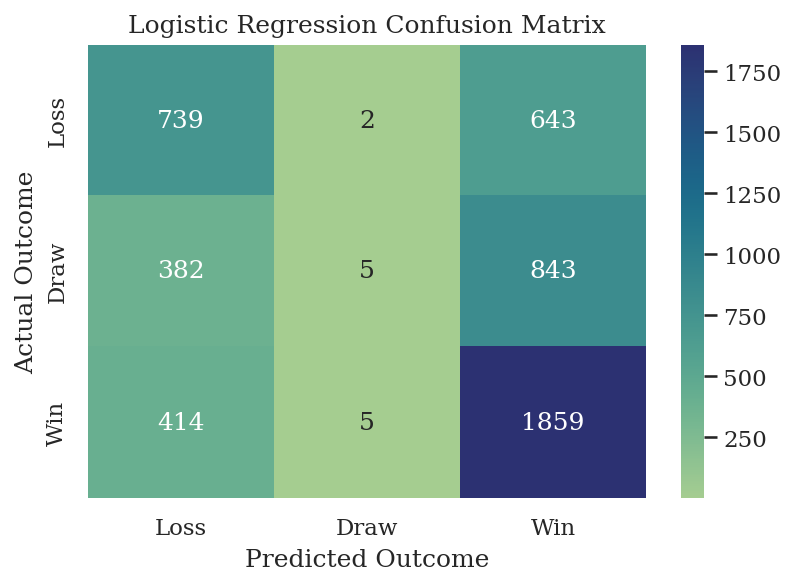

In [ ]:
#Confusion matrix for our logistic regression model
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[-1, 0, 1]), columns=['Loss', 'Draw', 'Win'], 
                                   index = ['Loss', 'Draw', 'Win'])
confusion_matrix_df
plt.figure(dpi = 150)
sns.heatmap(confusion_matrix_df, annot = True, fmt = 'g', cmap = 'crest')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.show()

The confusion matrix shows us that our model rarely ever predicts a draw, classifying draws in a much lower proportion than the actual proportion of games that result in draws. This means the model's accuracy must come largely from predicting wins and losses.

As a human, this makes sense. There is not much about two teams that would indicate that they are likely to draw, even if the teams are at a similar skill level. However, you can say with confidence if you believe one team is much more likely to win than another if you believe one team is much better than the other.

It may be for a similar reason that our model is more inclined to predict a win or a loss rather than a draw. It classifies draw in a much lower proportion than the actual proportion of games that result in draws.

## Random Forest Classifier
Now, we can try using a random forest classifier. We will fit this to our training data and predict using test data.

In [ ]:
#train and predict with a RandomForestClassifier AND PCA
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth=10, random_state=seed)
random_forest.fit(pca_x_train, y_train)
y_pred = random_forest.predict(pca_x_test)
random_forest_accuracy = random_forest.score(pca_x_test, y_test)

And let's take a look at its accuracy.

In [ ]:
random_forest_accuracy

0.5331152902698283

Similar to the logistic regressor! Let's see if it's confusion matrix looks similar too.

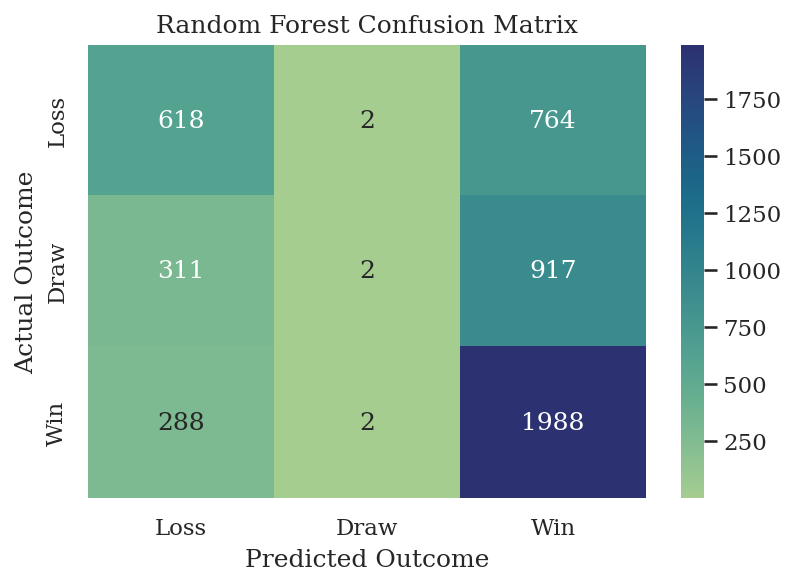

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot confusion matrix for Random Forest
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[-1, 0, 1]), columns=['Loss', 'Draw', 'Win'], 
                                   index = ['Loss', 'Draw', 'Win'])
confusion_matrix_df
plt.figure(dpi = 150)
sns.heatmap(confusion_matrix_df, annot = True, fmt = 'g', cmap = 'crest')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.show()

plt.savefig("cf2.png", bbox_inches='tight', dpi=300)
files.download("cf2.png")

A very similar looking confusion matrix! It seems the random forest has a similar decisionmaking process to that of the Logistic Regressor.

## Modeling Conclusion
Overall, we found that our simple linear regression model performed best at the task of predicting the goal difference of a game, out-performing regularized models and models trained with data transformed by PCA. This is likely a result of the types of features in our dataset, that are largely non-colinear. We were able to achieve $R^2$ values of around 0.2 at this task. Because the goal difference of a game is so hard to predict just based on the attributes of a team, we understand why this value is relatively low.

At the task of classifying the outcome of a game (win, loss, or draw) our Logistic Regression and Random Forest models performed very well, achieving around a 53% accuracy. This was shown to be much higher than guessing randomly or repeatedly guessing a control value. As a result, we are pleased with this level of accuraccy from these models!

Here are some visualizations of our final findings.

In [ ]:
classification_results_df = pd.DataFrame([['Logistic Regression', log_reg_accuracy, True],
              ['Random Forest Classifier', random_forest_accuracy, True]], columns=['Model', 'Accuracy', 'Used PCA'])

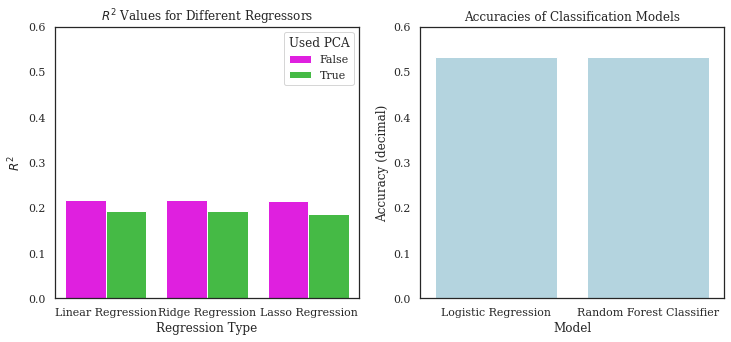

<Figure size 900x600 with 0 Axes>

In [ ]:
#visualize findings
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.figure(dpi = 150)

sns.barplot(ax=axes[0], data=regression_results_df, x='Regression Type', y='Score', hue='Used PCA', palette = ['magenta', 'limegreen'])
axes[0].set_title('$R^2$ Values for Different Regressors')
axes[0].set_ylim([0, 0.6])
axes[0].set_ylabel('$R^2$')
sns.barplot(ax=axes[1], data=classification_results_df, x='Model', y='Accuracy', color='lightblue')
axes[1].set_title('Accuracies of Classification Models')
axes[1].set_ylim([0, 0.6])
axes[1].set_ylabel('Accuracy (decimal)')
plt.show()
